# Neuronal Contributions to Electrophysiological Power Spectra

### MA 765 Course Project

### Mateo Umaguing

### 05/01/2025

*Abstract taken from 'Disentangling neuronal contributions to electrophysiological power spectra with filtered point process models.'*

*This uses code from my repository (https://github.com/mateouma/fpp-npx) designed for my rotation project with Dr. Emily P. Stephen.*

## Abstract

Electrophysiology is ubiquitous in studying the brain from micro- to macroscopic scales. Many neurobiological processes such as synaptic potentials, active dendritic processes, and action potentials collectively contribute to the power spectra at different frequencies, but spectral analysis techniques typically do not attempt to parameterize these processes. Our group recently showed that filtered point process (FPP) forward modeling can relate underlying processes to both oscillatory and aperiodic spectral structure in electrophysiological recordings. Here, we evaluate the ability of FPP-based inverse models to disentangle the dynamic activation levels of spiking units based on ultra-high frequency power (0.3 – 15 kHz) in cortical recordings from high-density laminar probes in monkeys. First, by taking advantage of information provided at high spatiotemporal resolution such as channel location, detected units (putative neurons) on each channel, and unit spike times and waveforms, we characterized the acute effects of individual neuron spiking dynamics on the power spectra of signals from nearby channels. We found that single unit action potentials lack sufficient power for decoding firing rate from high-frequency spectra, even on nearby contacts, as background activity dominates the spectrum. Next, we modeled this background activity as a superposition of putative cell type populations on nearby channels, each with characteristic waveform shapes and dynamic firing rates. Our model was able to capture spectral power between 300 – 1000 Hz, supporting the premise that spiking dominates this band, though individual cell type contributions remain indistinguishable due to waveform similarities. Finally, we quantify the performance of a simplified model, containing just broad-spiking and narrow-spiking unit populations, to decode dynamic firing rates. Overall, this work highlights the potential of FPP-based frameworks in identifying neurobiological contributions to electrophysiological signal power spectra with the possibility of extending to macroscales such as ECoG or EEG.

## Background

Electrophysiological recordings are comprised of rhythmic (oscillatory) and broadband (aperiodic) processes. Rhythmic contributions to the power spectra of local field potential (LFP) and macroscale recordings (ex. ECoG, EEG) have been thoroughly studied, but broadband contributions have not been fully investigated. Furthermore, how these processes interact and collectively produce the electrophysiological signals in recording is unknown. Filtered point process (FPPs) can model these processes as a superposition of discrete events with a characteristic filter, and recently a stochastic forward modeling framework has been proposed that can model how rhythmic and broadband spectral effects are generated by neurobiological processes (Bloniasz et al. 2024). Here, we will use FPP-based modeling to quantify how neuronal processes (i.e. spiking) contribute to the electrophysiological power spectra.

## Scientific questions

On extracellular channels dominated by the spiking of a single neuron, is the firing rate the main contributor to the power spectrum of the signal? Can the firing rate be extracted using FPP-based inverse modeling? Can the time-varying firing rate be extracted?

What comprises the components of the power spectrum not explained by firing rate?

Is the firing rate of specific neuronal subpopulations represented in the power spectrum?

## Dataset

This project will primarily use two datasets collected from the dorsolateral prefrontal cortex (DLPFC) of a rhesus macaque with Neuropixels NHP 1.0 probes, courtesy of Dr. Chandramouli Chandrasekaran, Tian Wang, and Eric Kenji Lee. These contain the local field potential (LFP) signals collected from 384 dual-band (AP, 30 kHz; LFP, 2.5 kHz) channels along a 45 mm shank. In the first dataset, the monkey is awake and resting, and in the second dataset, the monkey is performing the checkerboard task (2AFC reaction time task). There is also a third dataset collected from anterior cingulate cortex (ACC) by Dr. Chandrasekaran and Pierre Boucher during anasthesia. Each dataset is spike-sorted and manually curated with Kilosort4 and phy, yielding the unit spike times, channel location, individual waveforms, and template waveforms (the filter that is continuously updated in the spike sorting algorithm to detect spikes in the signal).

## Imports and display settings

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

import fppnpx as fn
from fppnpx.FPPGLM import FPPGLM
from fppnpx.signalfuncs import load_signal, gen_all_channel_signals
from wavemapnpx.WaveMAPClassifier import WaveMAPClassifier

/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CUSTOM_PAL_SORT_3 = ['#5e60ce', '#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da', '#1eb43a']
cmap = colormaps.get_cmap('Set1')

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Preliminary results

### Loading data

In [4]:
apath = "/Users/mateouma/Downloads/monkey datasets/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0_t0.exported.imec0.ap-001.bin"
cpath = "/Users/mateouma/Downloads/monkey datasets/cluster_info_task.tsv"
wpath = "/Users/mateouma/Downloads/monkey datasets/20230630_DLPFCwaveforms.mat"

fs = 30000
time_window = [100,123] # seconds within the recording

signal_dataset = load_signal(appath=apath, time_window=time_window, fs=fs, cipath=cpath, wfpath=wpath)
channel_signals = gen_all_channel_signals(signal_dataset, 300, False)

Generated 112 channel signals.


Here, we begin working with a 23-second excerpt of the LFP data. The generated variable `channel_signals` is a dict containing the cluster information, waveforms, spike times, and time series for each of the channels with units found on them. The following is the time series for a channel, and the triangles indicate the spikes of a unit localized on that channel.

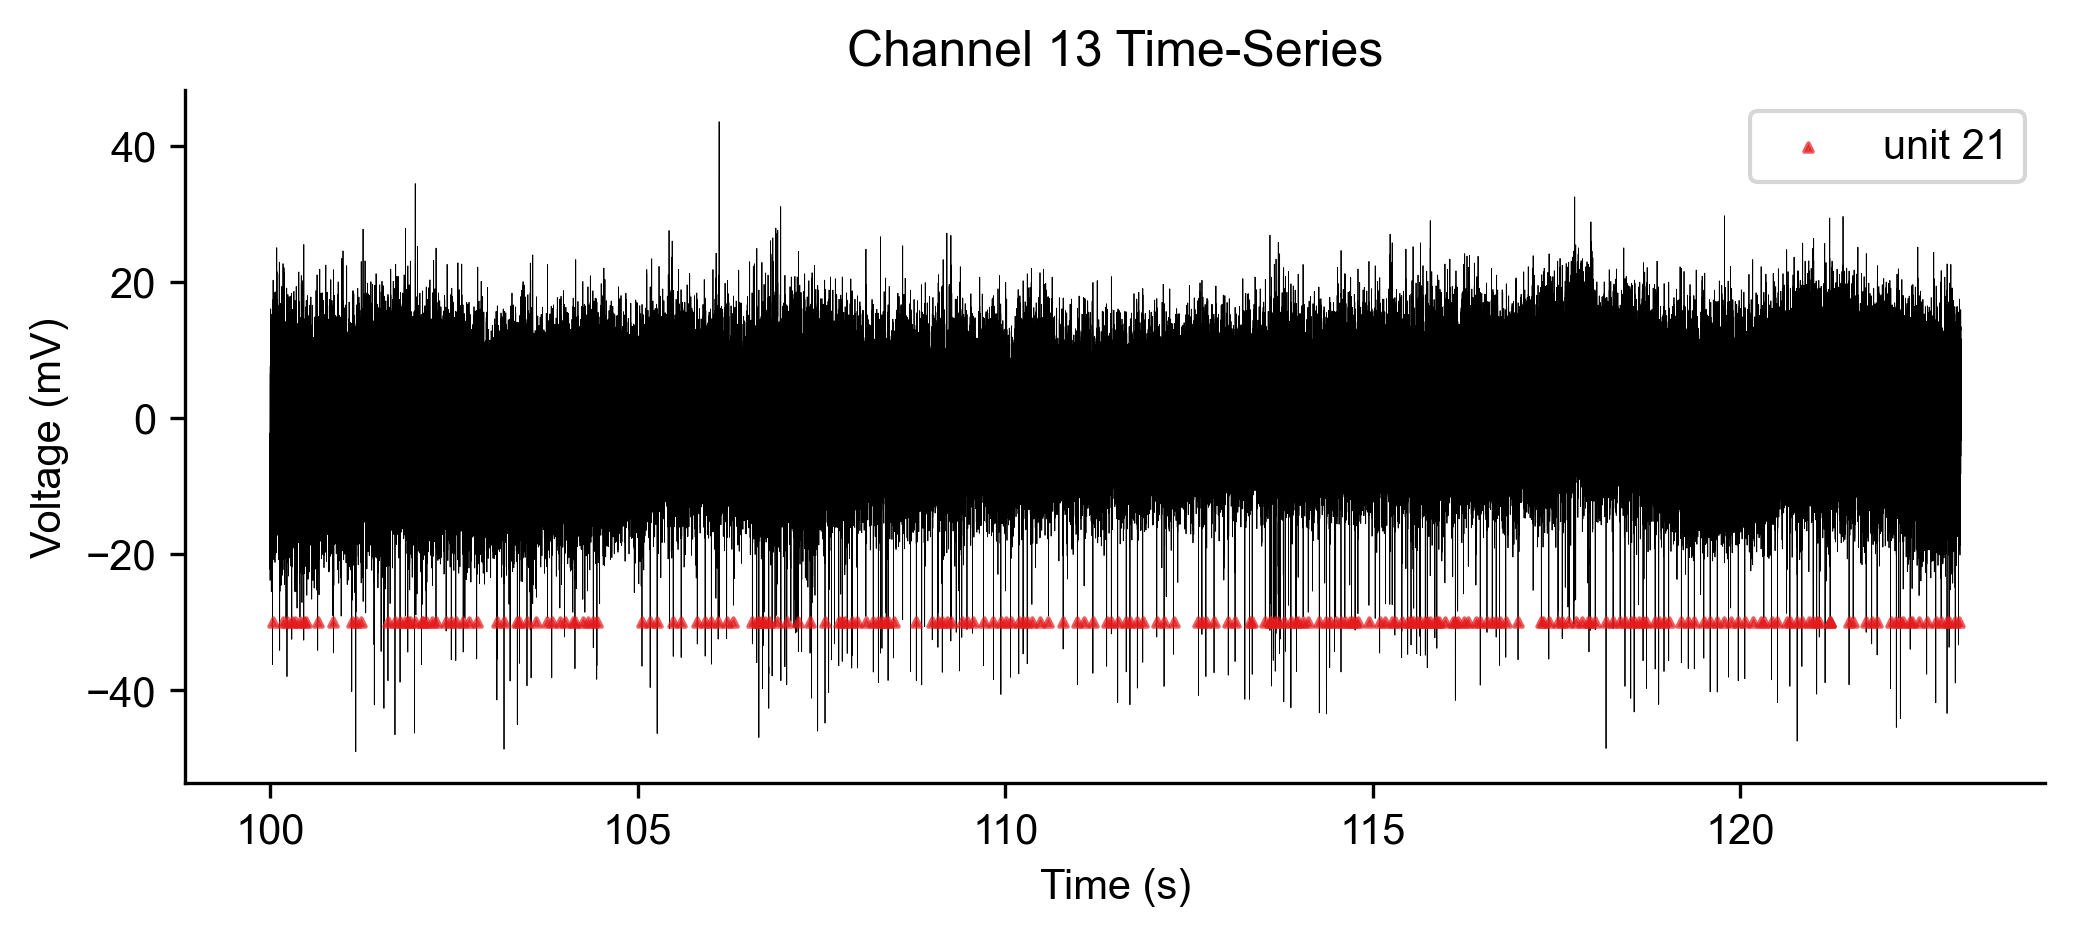

In [5]:
channel_signals["ch13"].plot_signal()

As we can see, the spikes of the unit are clearly visible on the channel, but there is a lot of background activity. The following is a channel with a high spiking SNR for the unit.

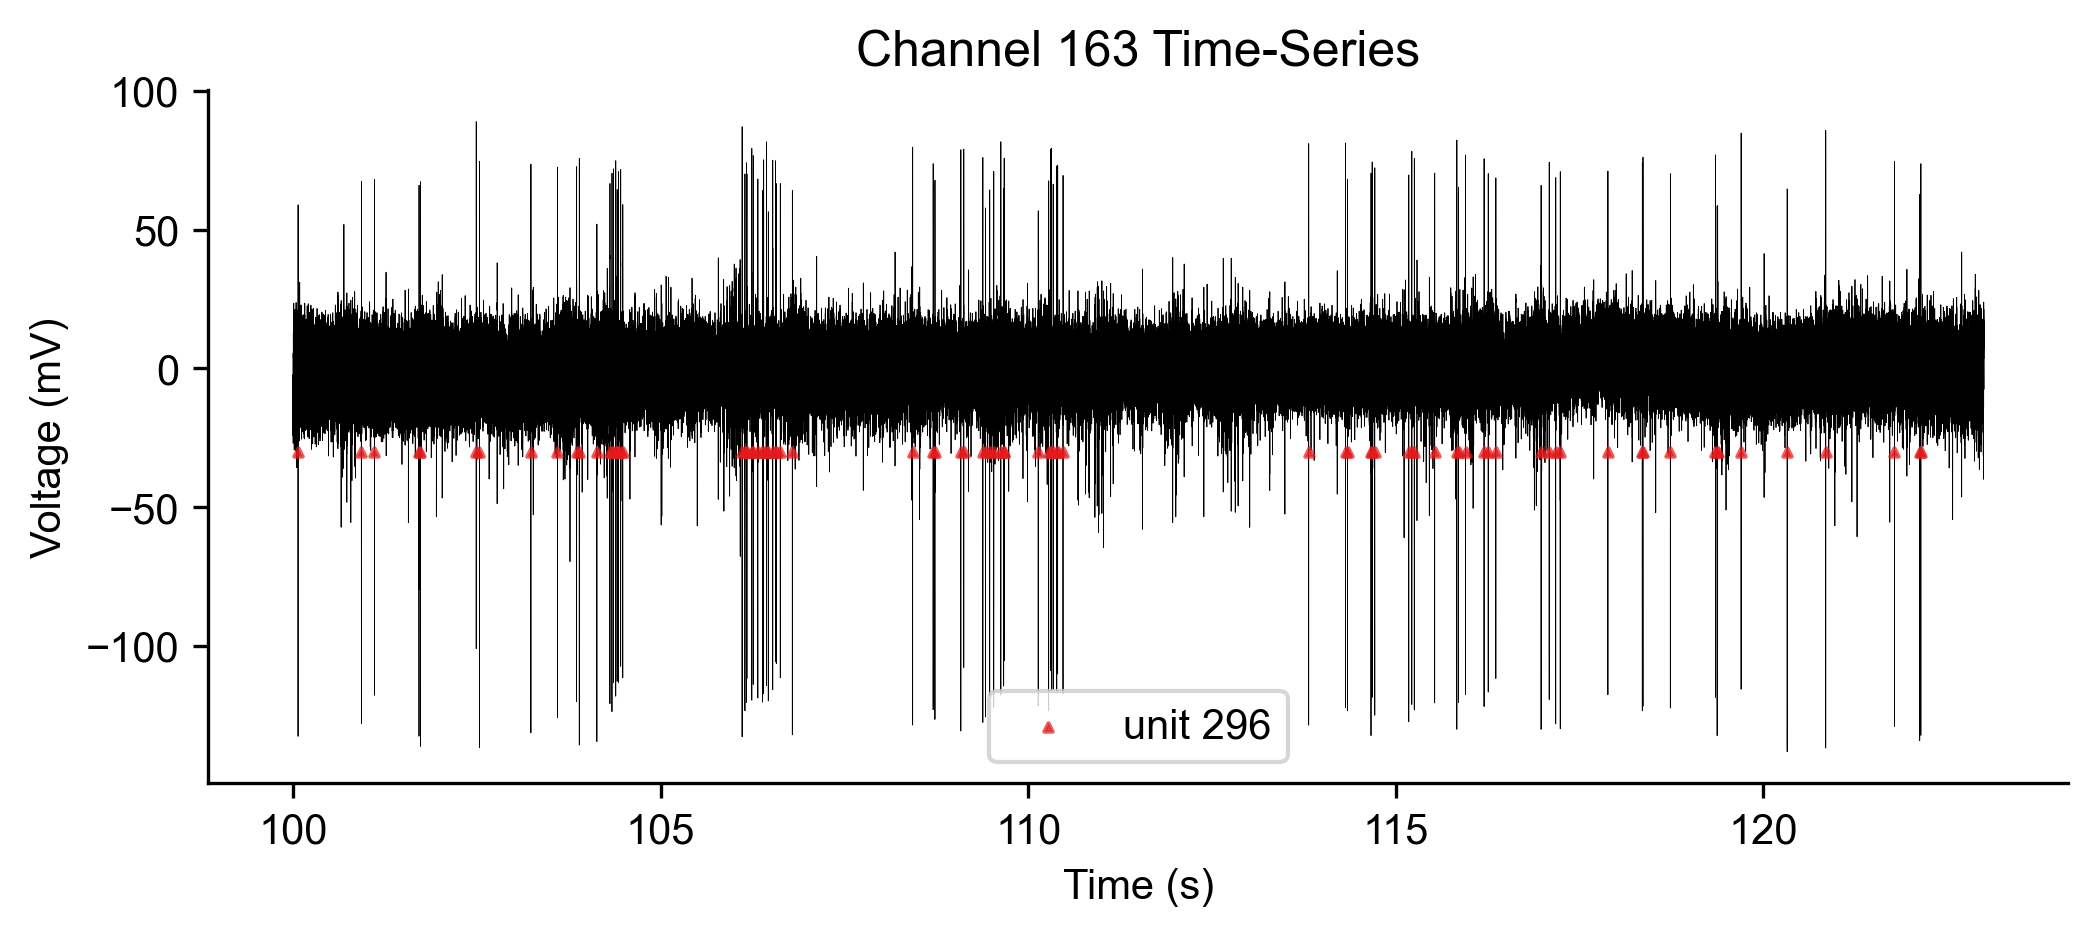

In [6]:
channel_signals['ch163'].plot_signal()

Lastly, here is a channel with the spikes of many units visible on the time-series. There are even other units mainly detected on other channels that are visible on the trace.

In [7]:
# additional units from other channels found on the time-series
add_spikes = [
    channel_signals['ch205'].spike_times[374],
    channel_signals['ch205'].spike_times[375]
]

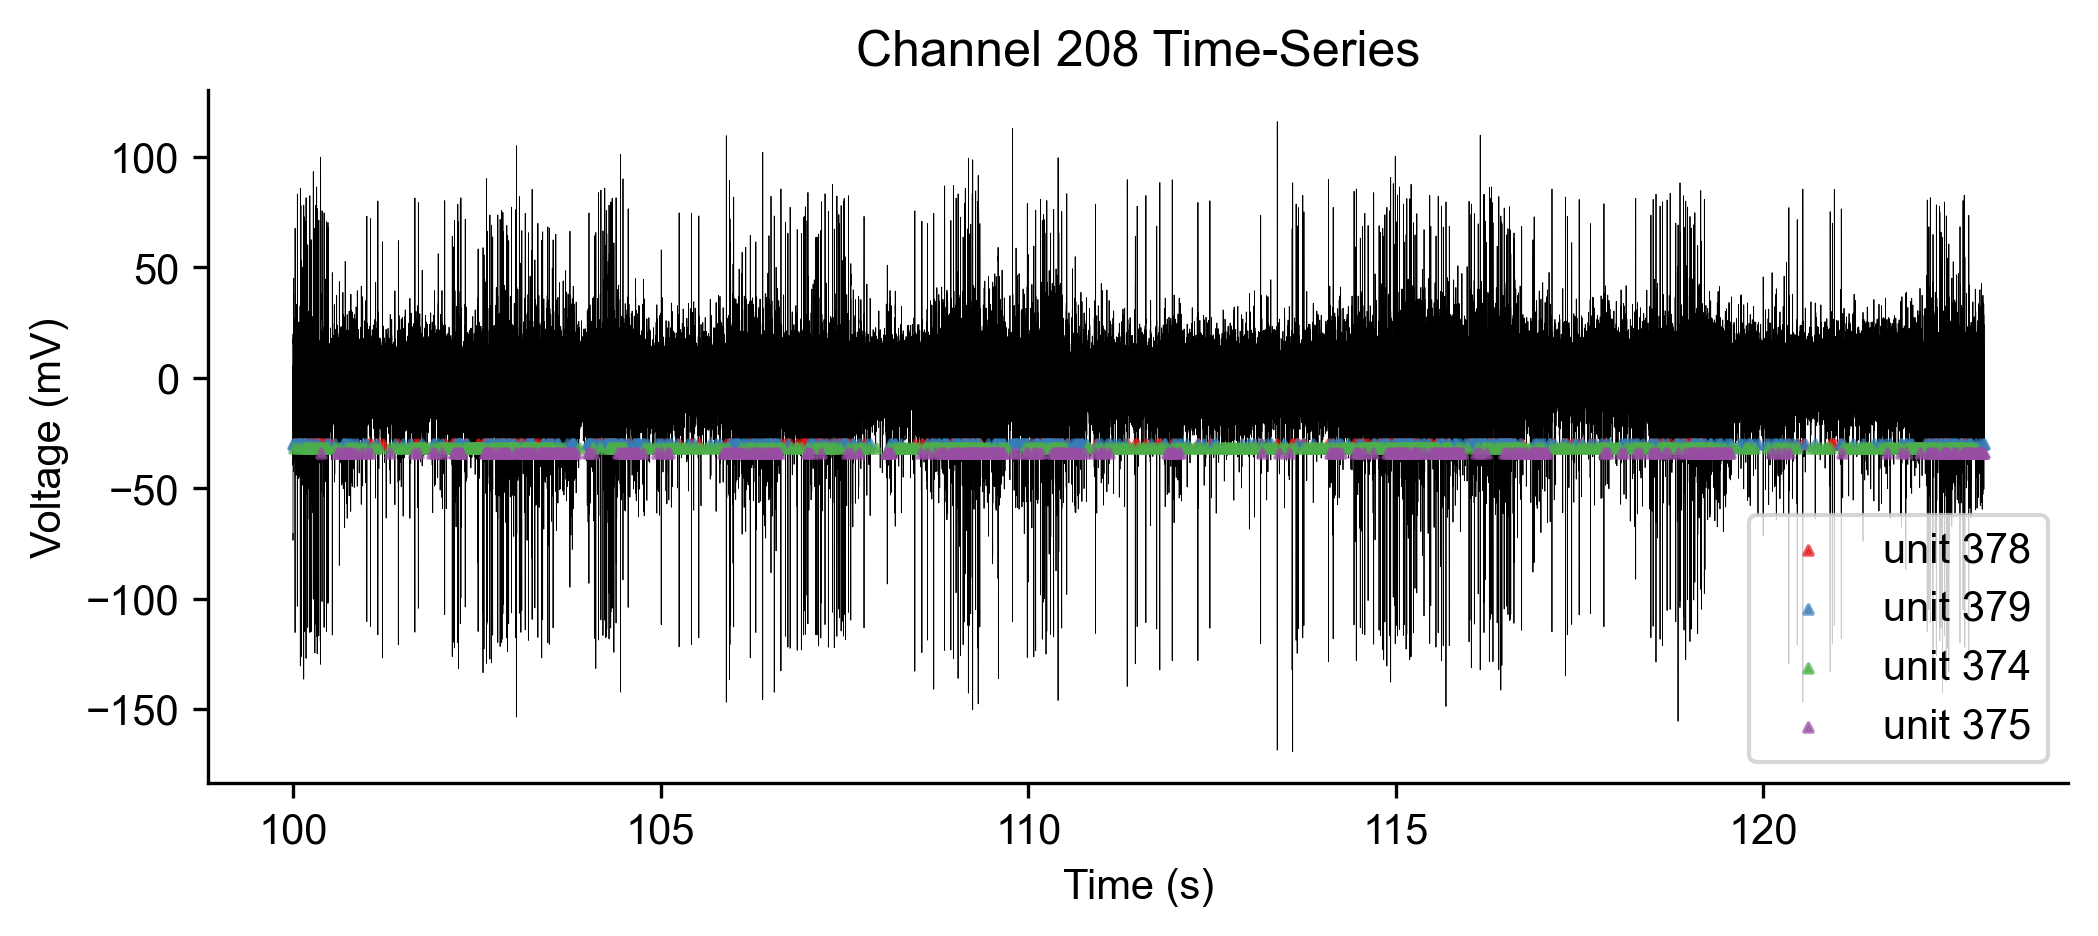

In [8]:
channel_signals['ch208'].plot_signal(additional_spikes=add_spikes, add_spk_units=[374, 375])

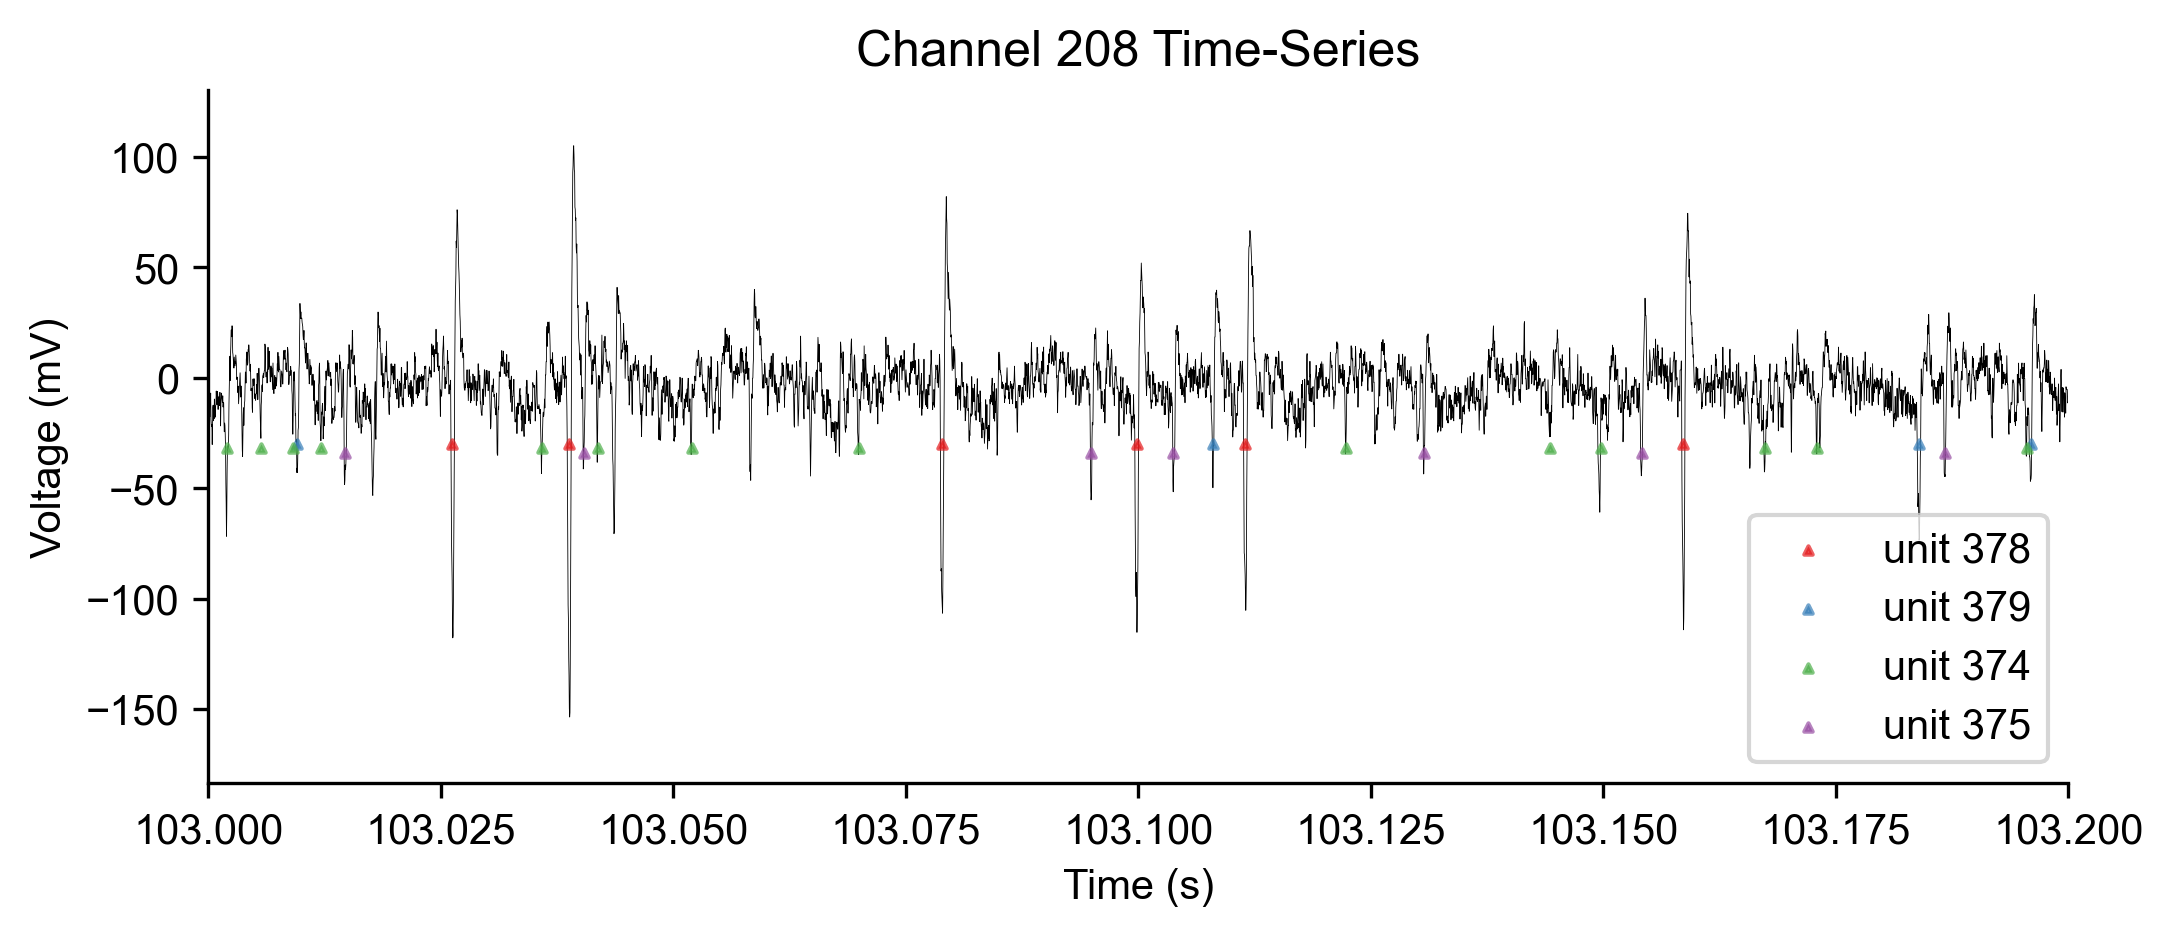

In [9]:
channel_signals['ch208'].plot_signal(additional_spikes=add_spikes, add_spk_units=[374, 375], xlim=(103,103.2))

Zoomed in, we can clearly see consistent spiking of the 4 units located on both channels 208 and 205 as well as other units not labeled.

### Power spectra

Since we are quantifying the effects of neuronal processes on the power spectra, we will compute and plot the spectra of the signals. We will be using the `spectral_connectivity` package from Eric L. Denovellis et al. to compute the multitapered spectra. The default time-halfbandwidth product is 3, therefore we can calculate the frequency resolution of our 23-second long signal and the number of tapers used.

Frequency resolution $2W$:
$$
TW=3\\
23W=3\\
W=3/23 \\
2W = 6/23 \approx 0.26087
$$

No. tapers:
$$
2TW-1 = \text{No. tapers}\\
2(3)-1 = 5\text{ tapers}
$$

In [15]:
ch13_PSD,mt_freqs = fn.spectrafuncs.multitaper_psd(channel_signals['ch13'].time_series, fs=fs, start_time=channel_signals['ch13'].time_axis)
ch163_PSD,mt_freqs = fn.spectrafuncs.multitaper_psd(channel_signals['ch163'].time_series, fs=fs, start_time=channel_signals['ch13'].time_axis)
ch208_PSD,mt_freqs = fn.spectrafuncs.multitaper_psd(channel_signals['ch208'].time_series, fs=fs, start_time=channel_signals['ch13'].time_axis)

Multitaper frequency resolution: 0.2608695652173913
Multitaper number of tapers: 5
Multitaper frequency resolution: 0.2608695652173913
Multitaper number of tapers: 5
Multitaper frequency resolution: 0.2608695652173913
Multitaper number of tapers: 5


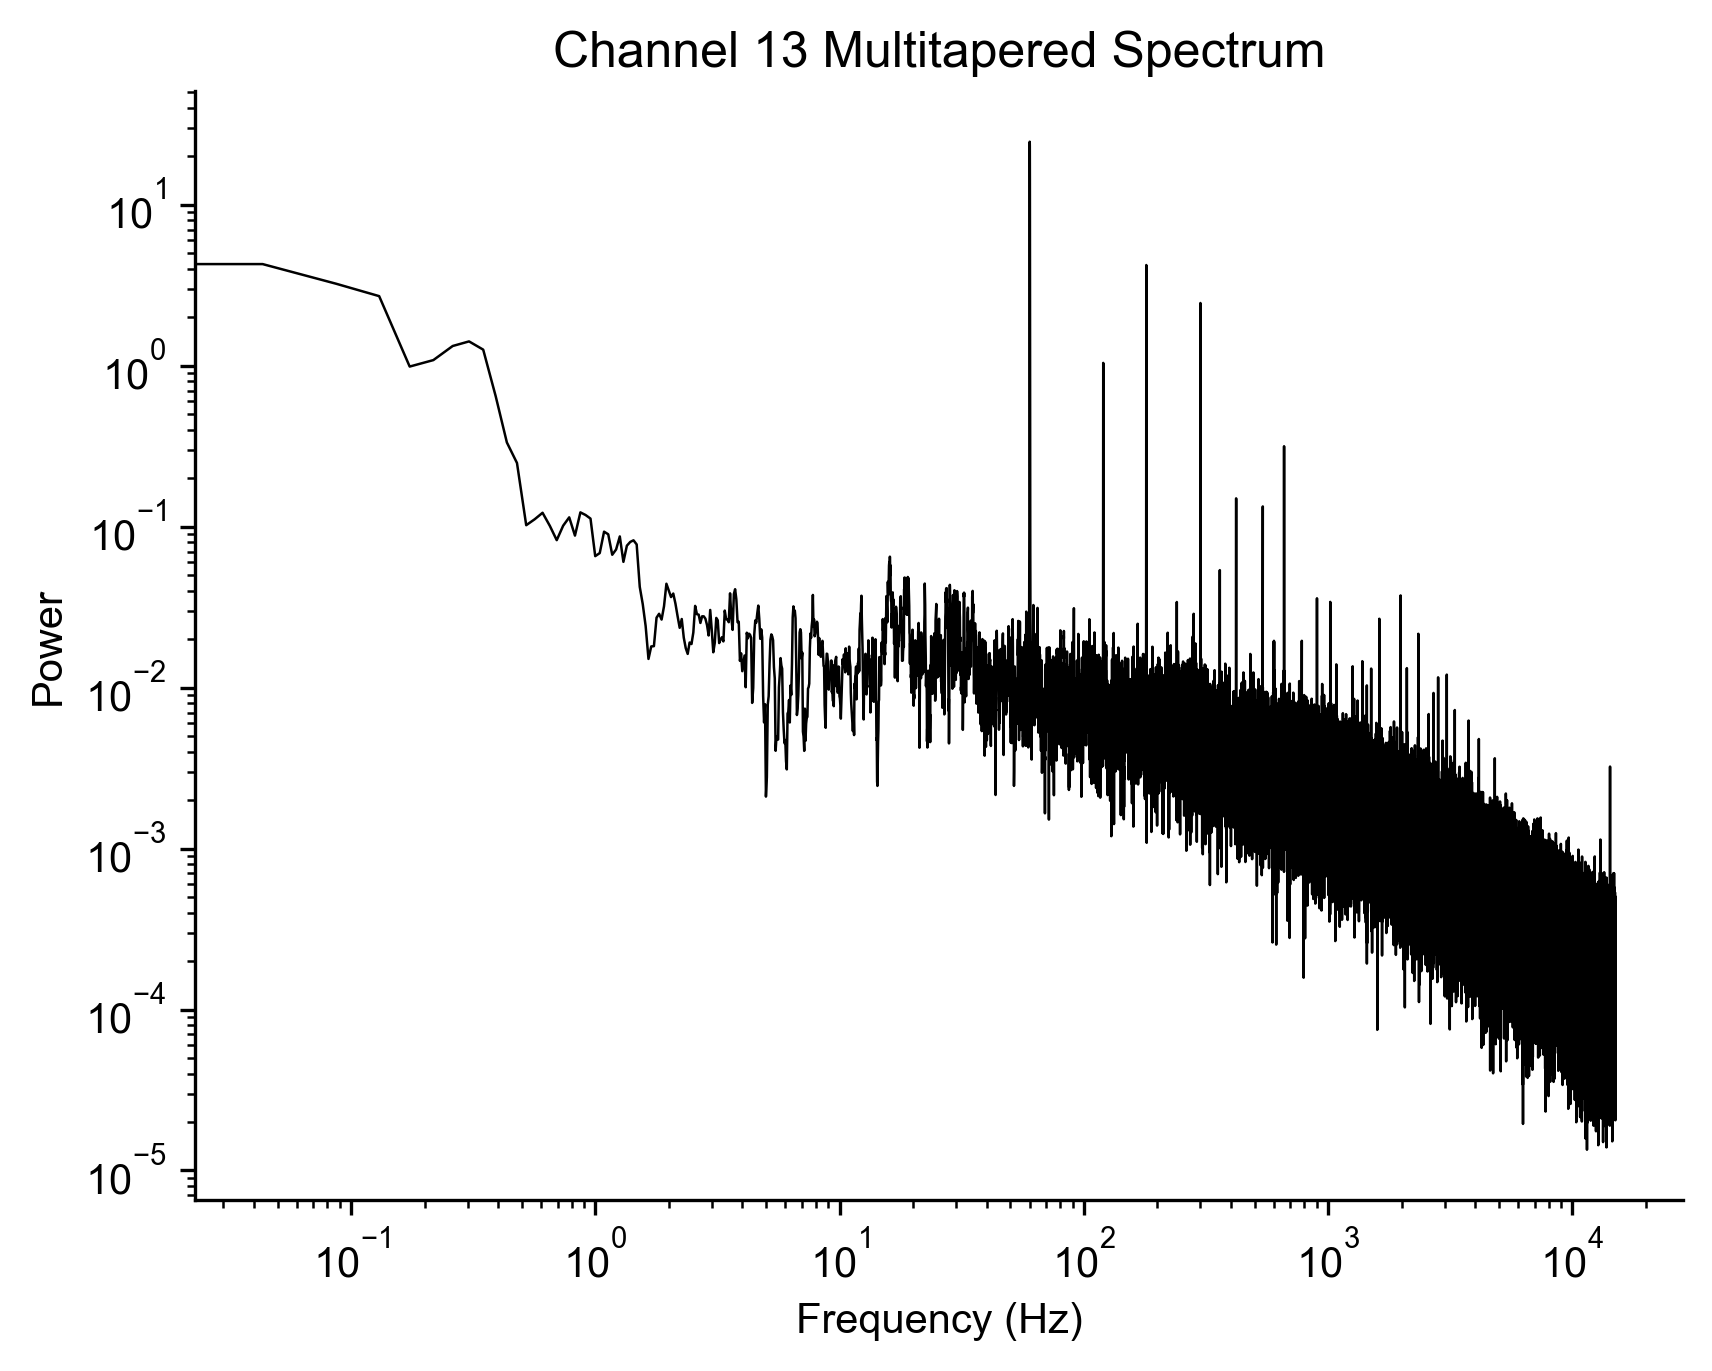

In [16]:
plt.figure(dpi=300)
plt.loglog(mt_freqs, ch13_PSD, color='k', linewidth=0.6)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Channel 13 Multitapered Spectrum")
plt.show()

Though we use harmonic regression to remove line noise, we can still clearly see it in the spectrum.

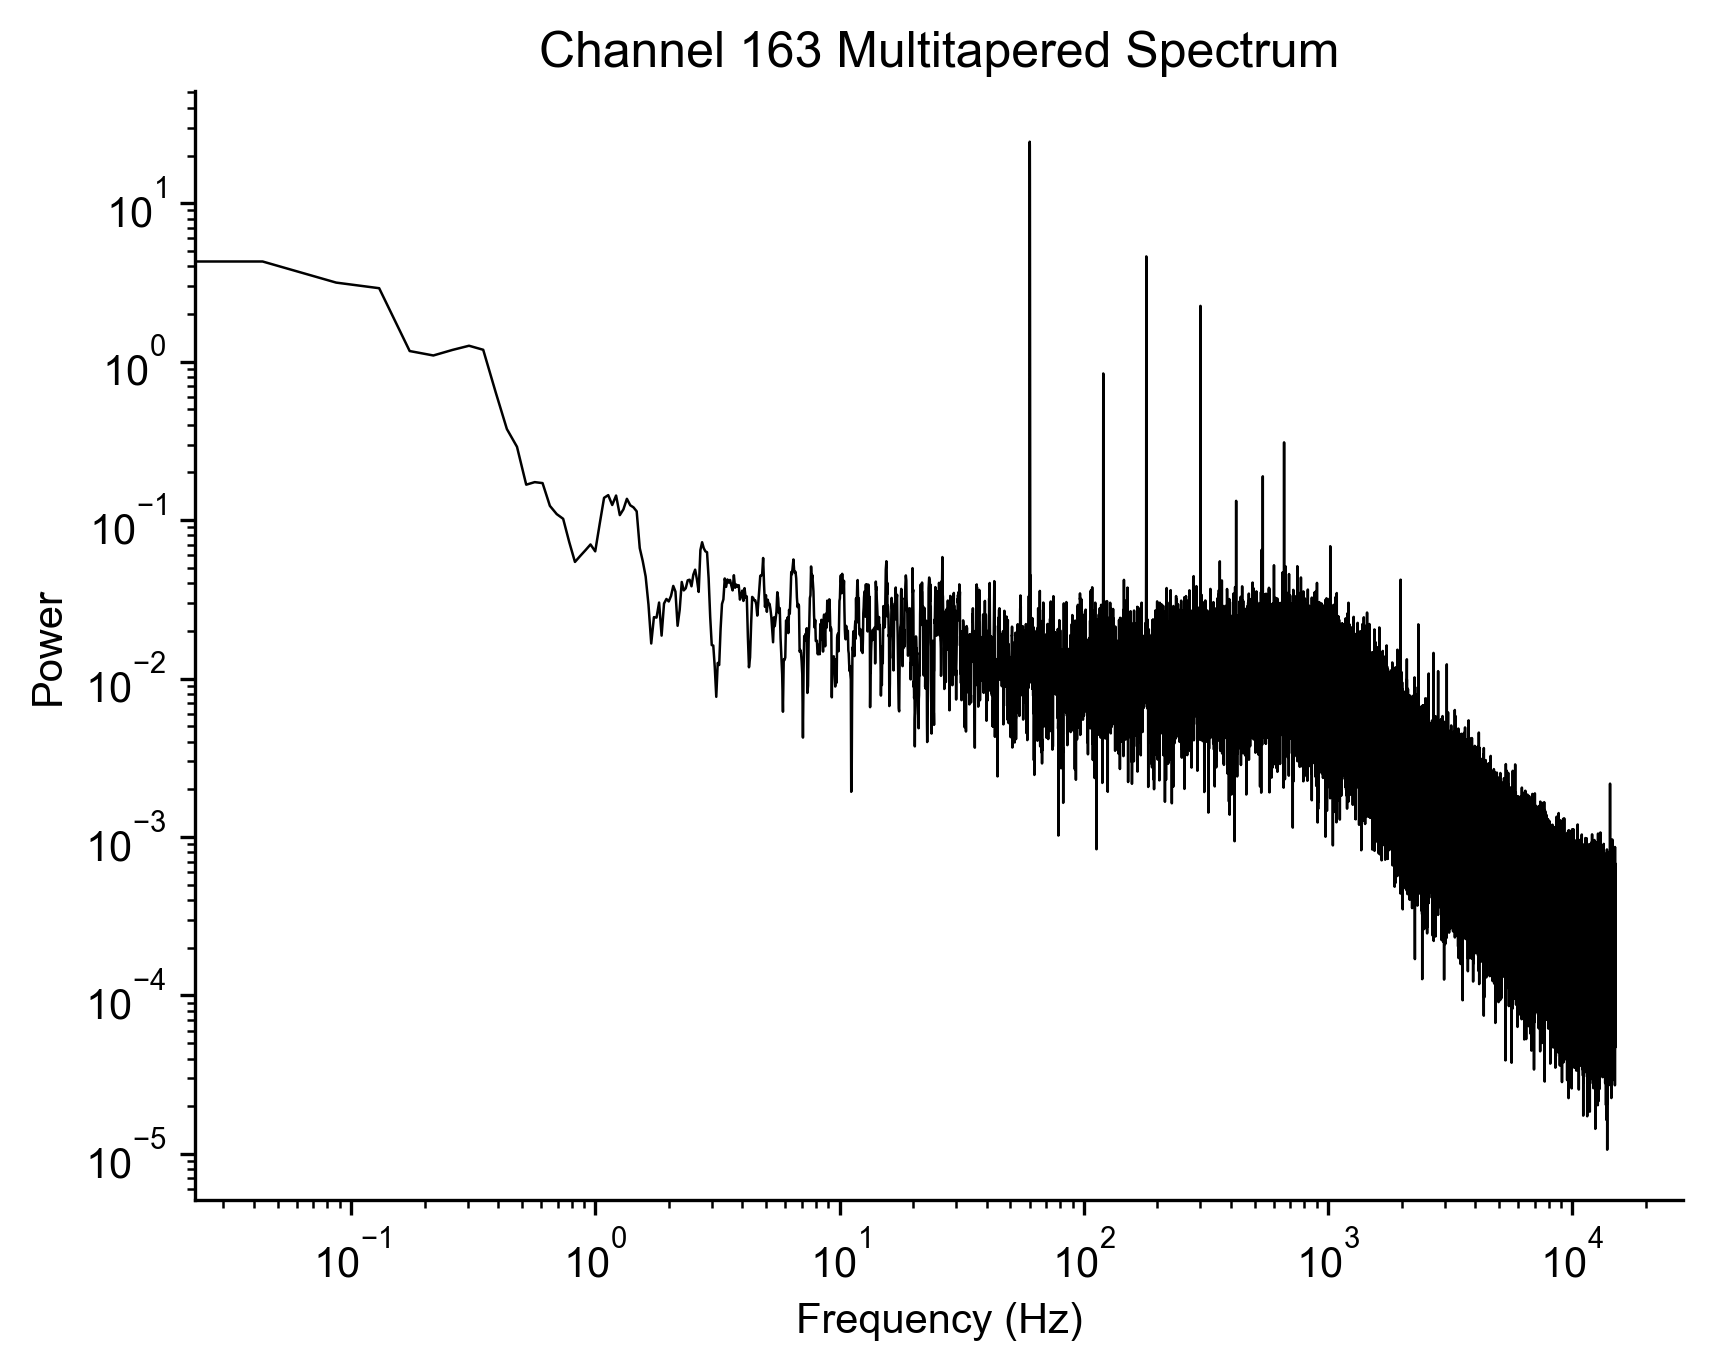

In [17]:
plt.figure(dpi=300)
plt.loglog(mt_freqs, ch163_PSD, color='k', linewidth=0.6)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Channel 163 Multitapered Spectrum")
plt.show()

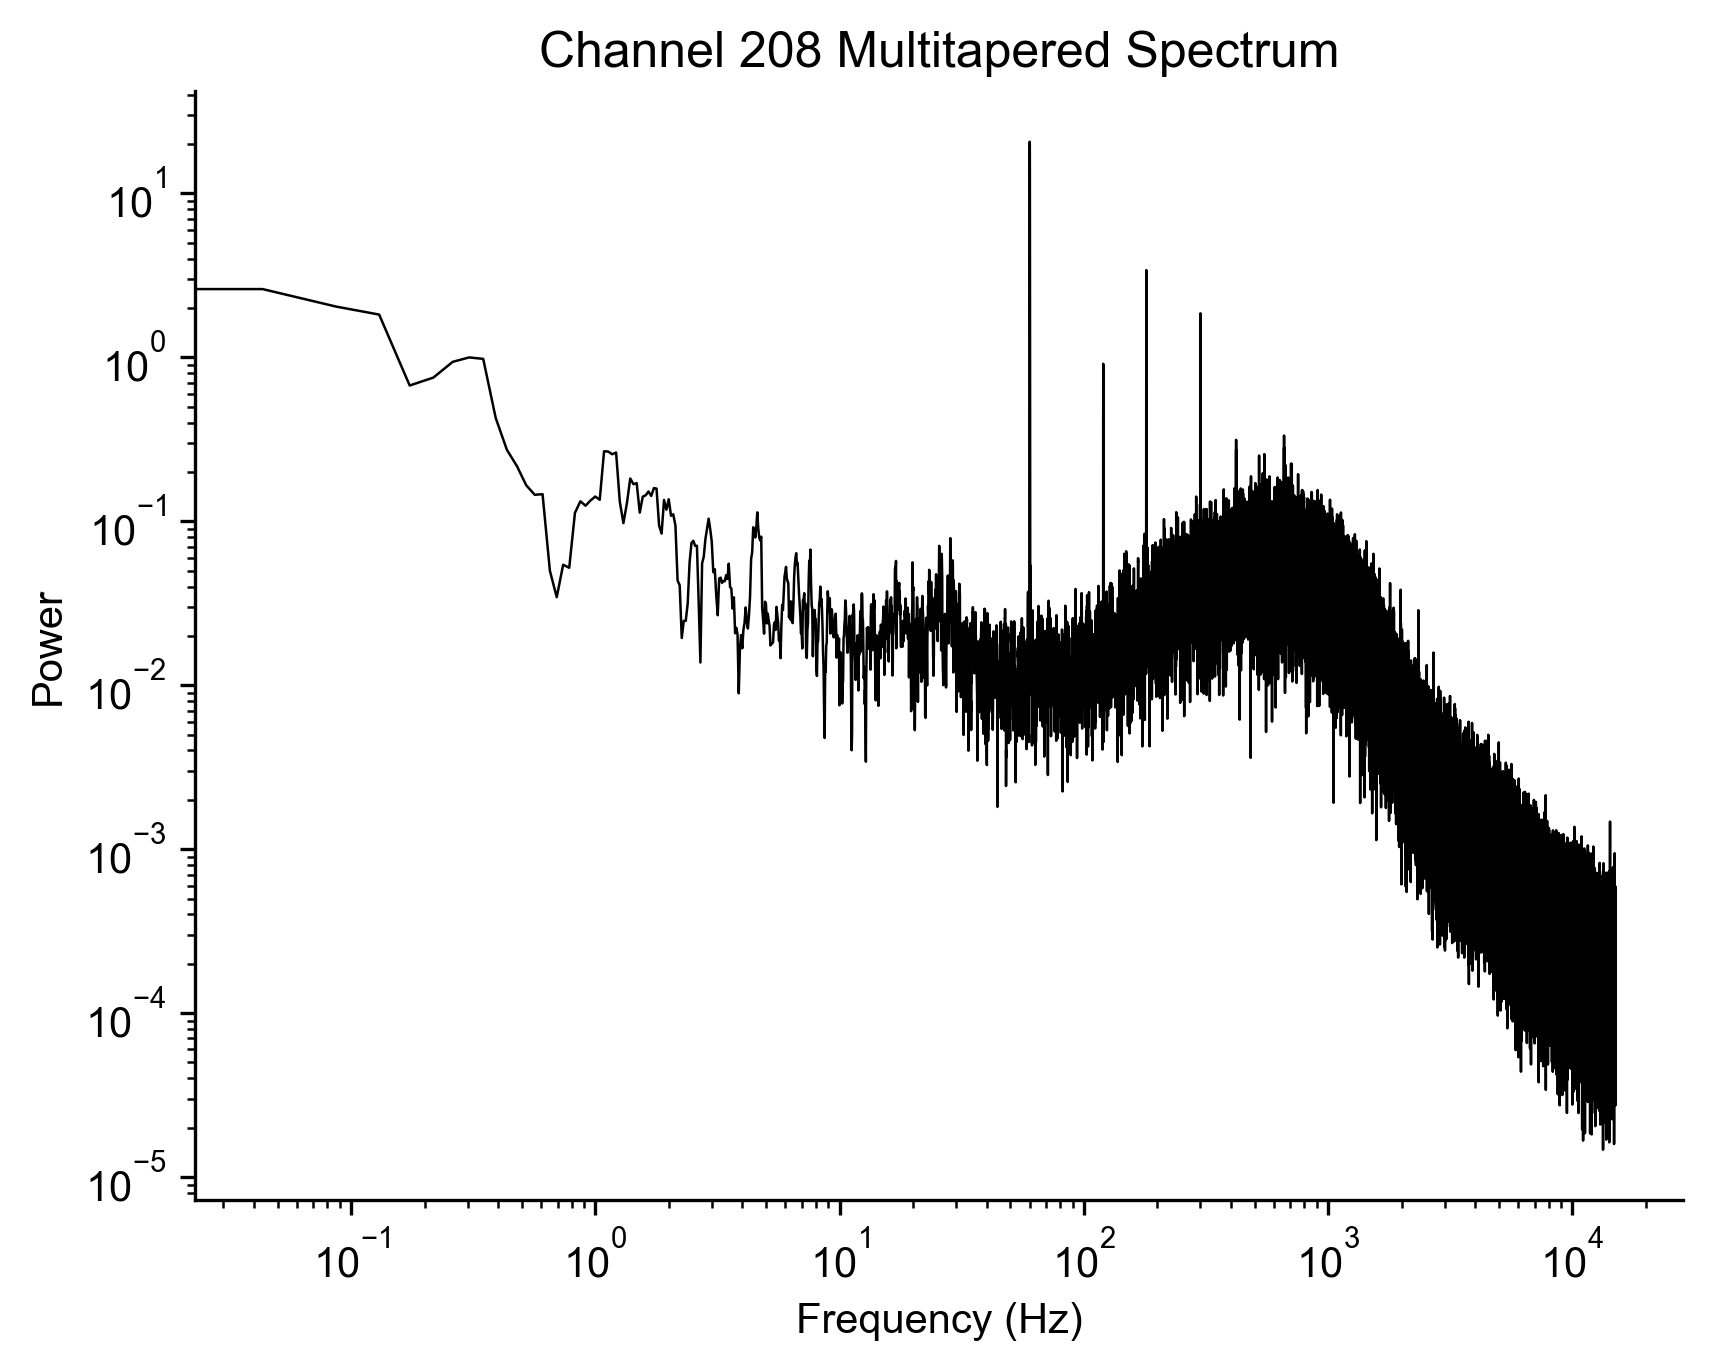

In [18]:
plt.figure(dpi=300)
plt.loglog(mt_freqs, ch208_PSD, color='k', linewidth=0.6)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Channel 208 Multitapered Spectrum")
plt.show()

The signals with higher spiking SNR have a more pronounced bump within the 100-1000 frequency band.

### Spectrograms

To look at how the spectra evolve throughout time, we will plot the spectrograms. We will use a 1-second window with a 0.5-second step as well as a slightly less fine frequency resolution of 0.5 Hz, yielding a time-halfbandwidth product of 5.75.

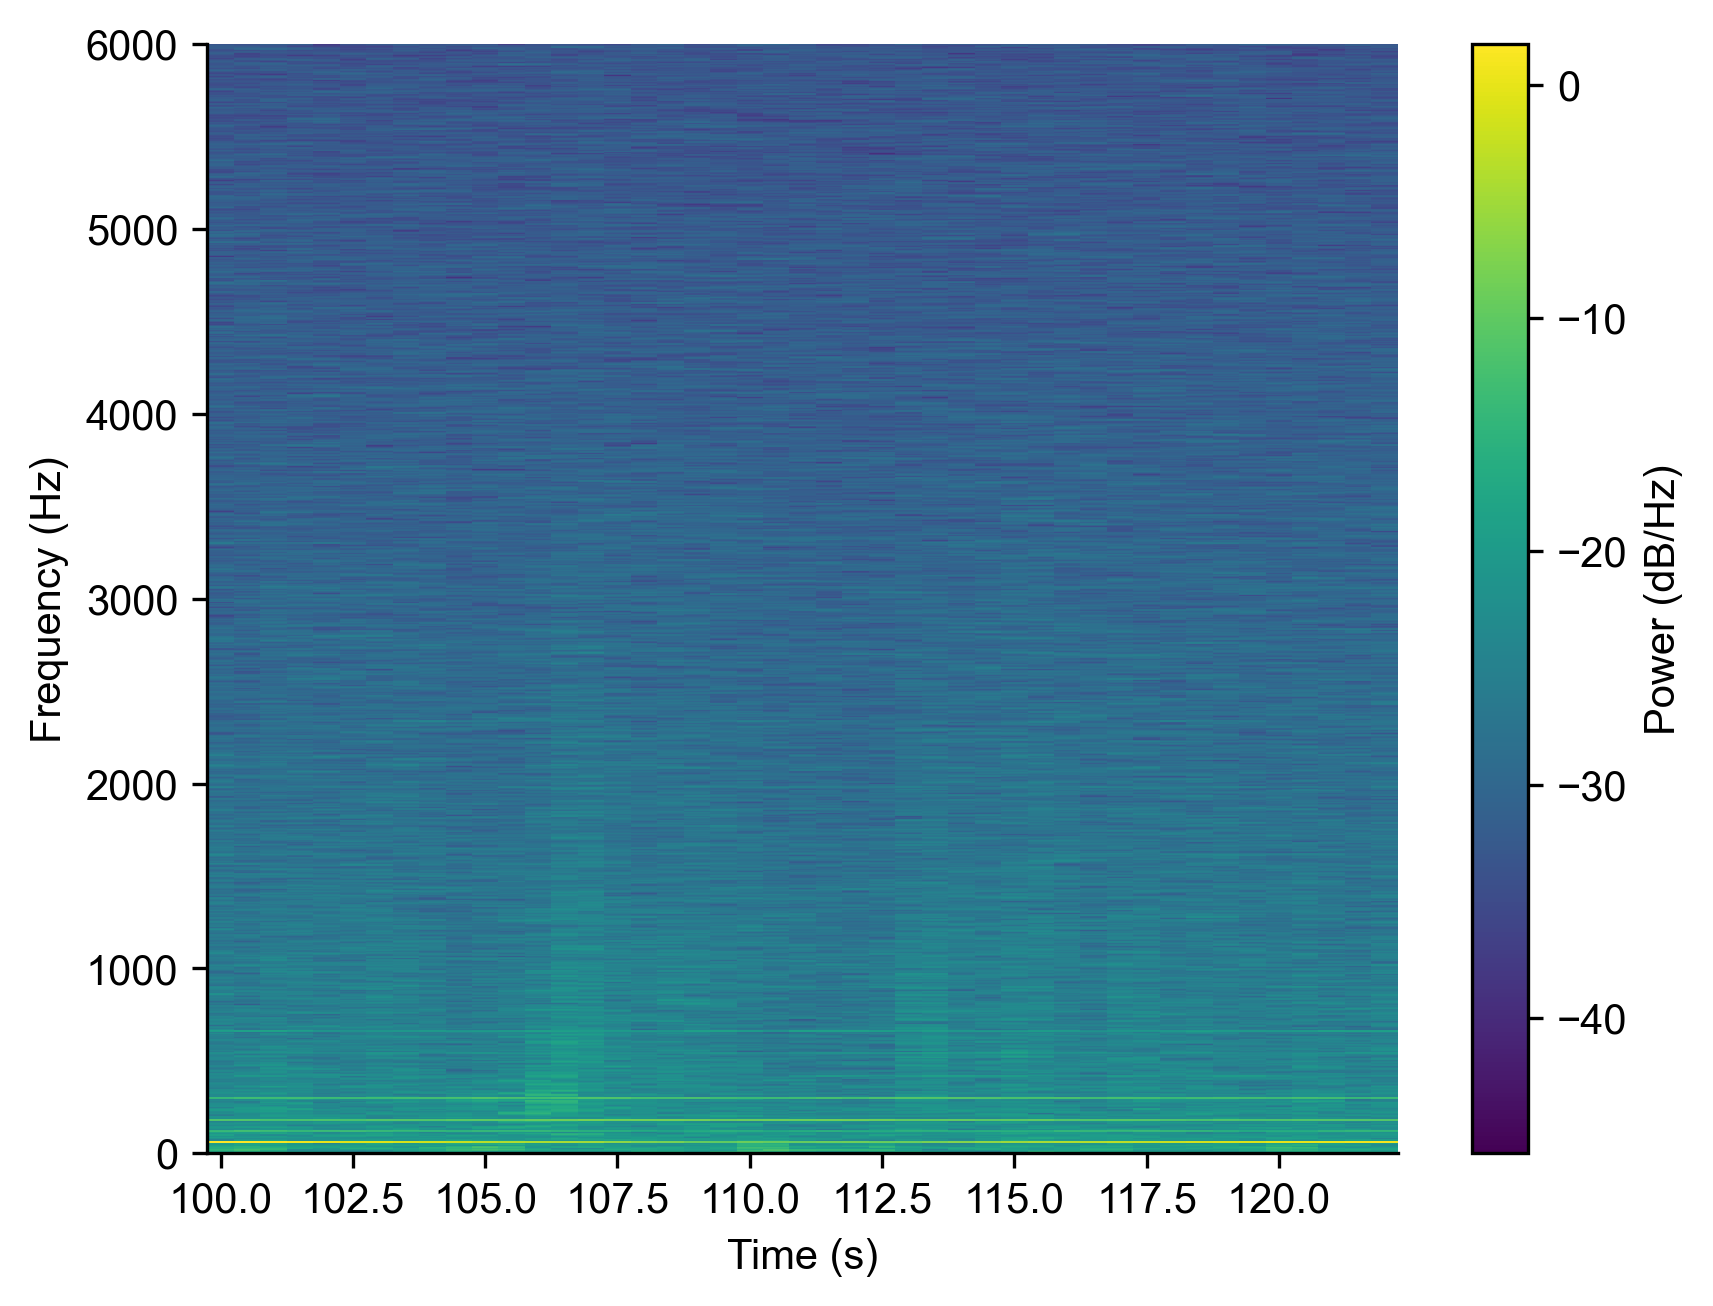

In [34]:
fn.spectrafuncs.plot_spectrogram(channel_signals['ch13'].time_series, fs, time_halfbandwidth_product=5.75,
                                 window_duration=1,
                                 window_step=0.5,
                                 start_time=channel_signals['ch13'].time_axis[0])

Channel 163:

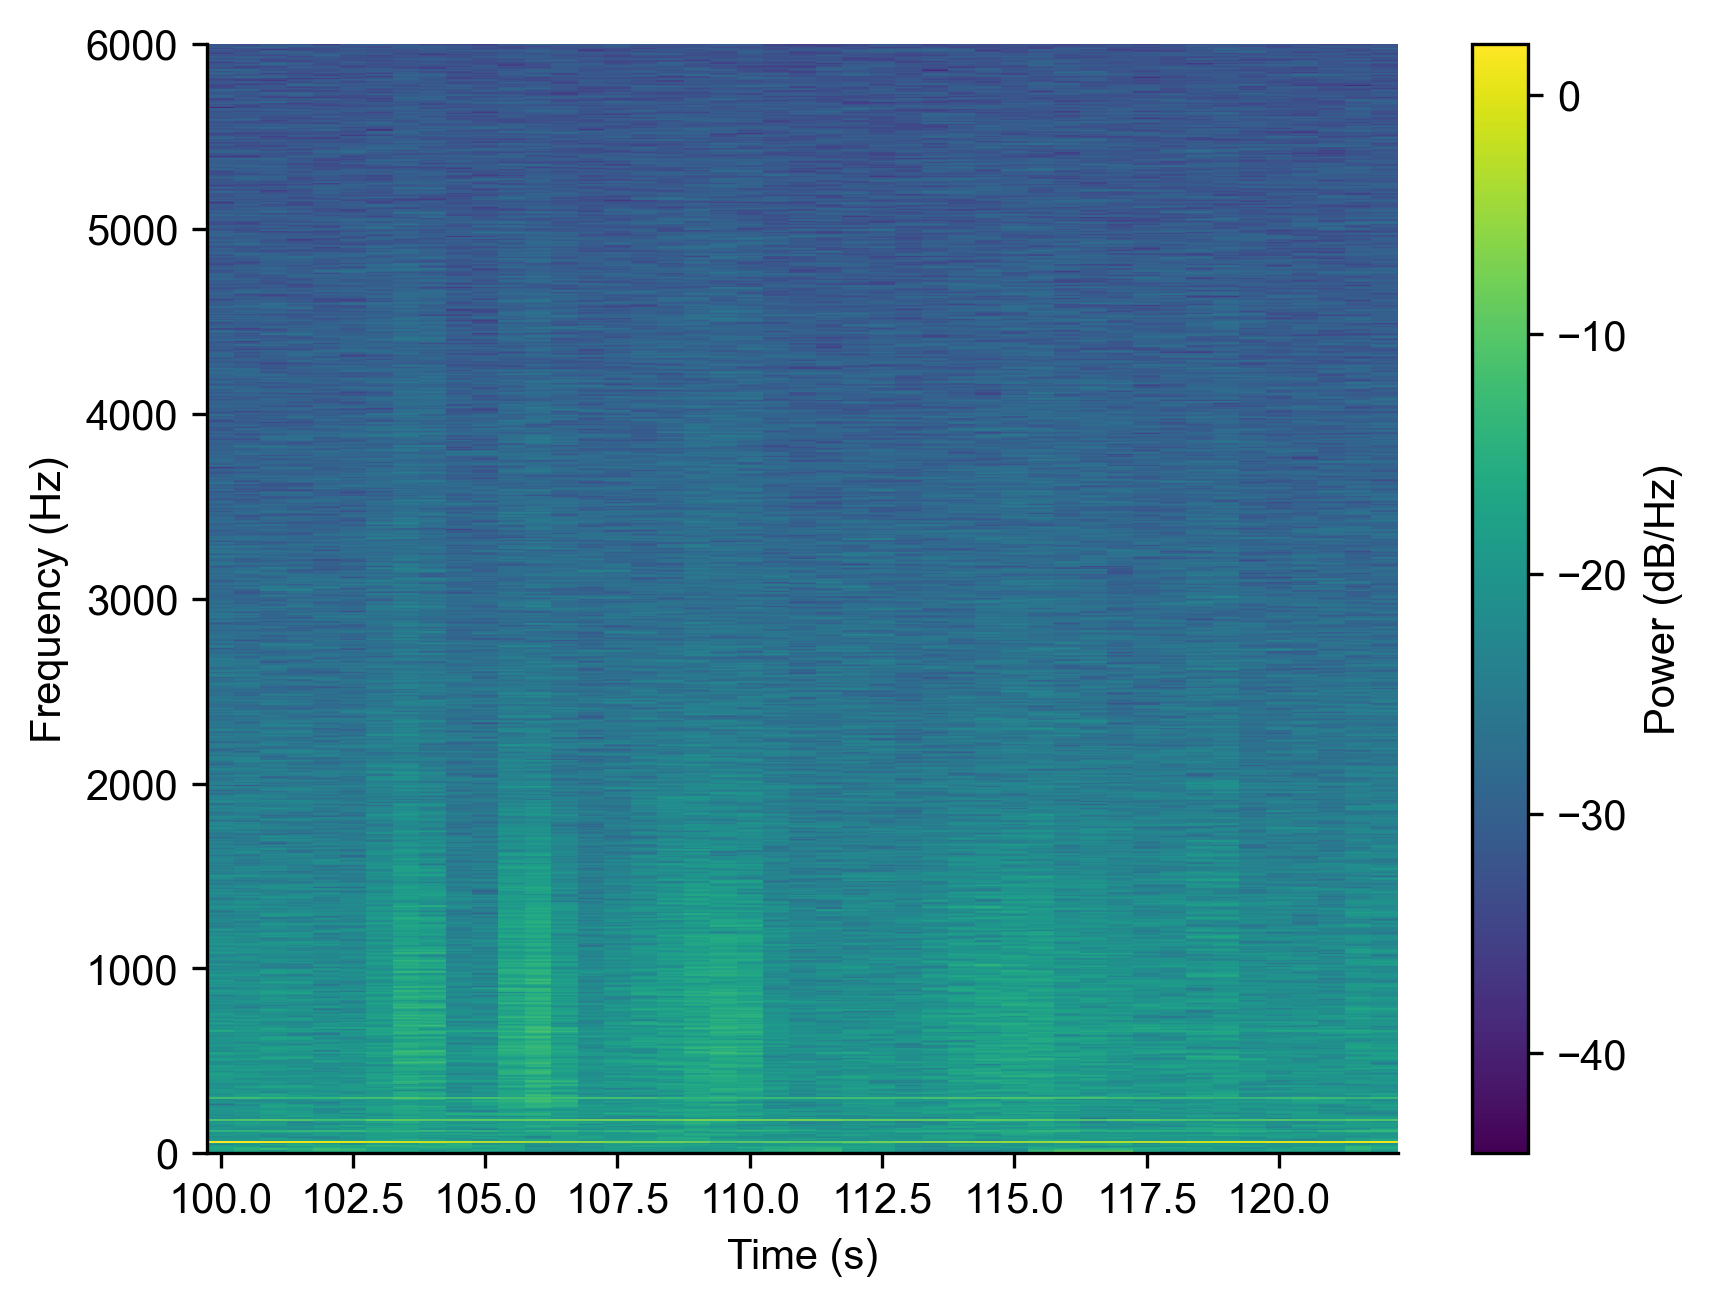

In [35]:
fn.spectrafuncs.plot_spectrogram(channel_signals['ch163'].time_series, fs, time_halfbandwidth_product=5.75,
                                 window_duration=1,
                                 window_step=0.5,
                                 start_time=channel_signals['ch13'].time_axis[0])

Channel 208:

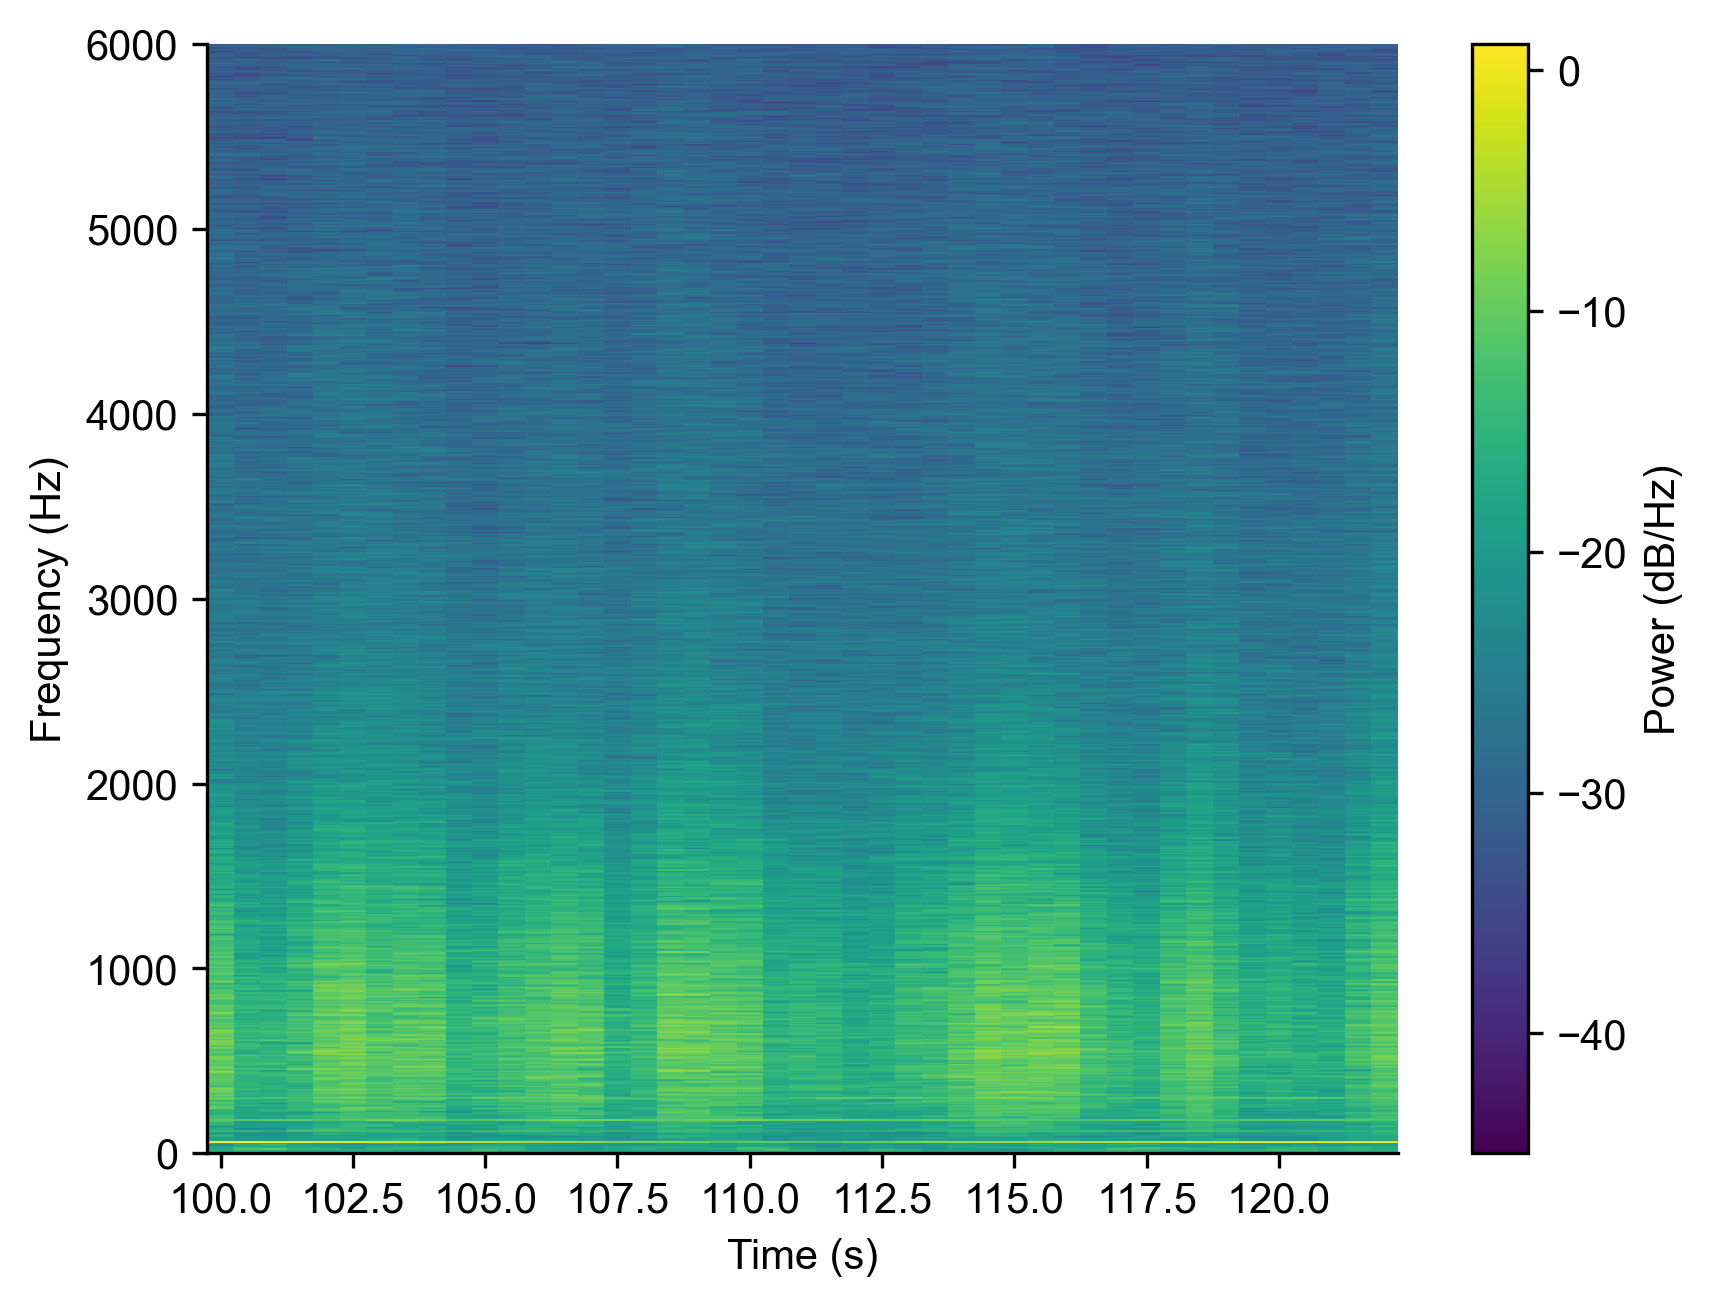

In [36]:
fn.spectrafuncs.plot_spectrogram(channel_signals['ch208'].time_series, fs, time_halfbandwidth_product=5.75,
                                 window_duration=1,
                                 window_step=0.5,
                                 start_time=channel_signals['ch13'].time_axis[0])

### Spike waveforms

We will be interrogating the contributions of spikes to the spectra, therefore we will calculate and plot the time domain, frequency domain, and power spectral density of the spike waveforms. The spike events will be modeled as point processes and their waveforms will be modeled as their filters.

In [5]:
u21_instances,u21_filters,theor_freqs = channel_signals['ch13'].generate_unit_filters(selected_unit=21, truncate_idx=58)
u296_instances,u296_filters,_ = channel_signals['ch163'].generate_unit_filters(selected_unit=296, truncate_idx=74)
u378_instances,u378_filters,_ = channel_signals['ch208'].generate_unit_filters(selected_unit=378)
u379_instances,u379_filters,_ = channel_signals['ch208'].generate_unit_filters(selected_unit=379)
u374_instances,u374_filters,_ = channel_signals['ch205'].generate_unit_filters(selected_unit=374)
u375_instances,u375_filters,_ = channel_signals['ch205'].generate_unit_filters(selected_unit=375)

Unit 21 filters:

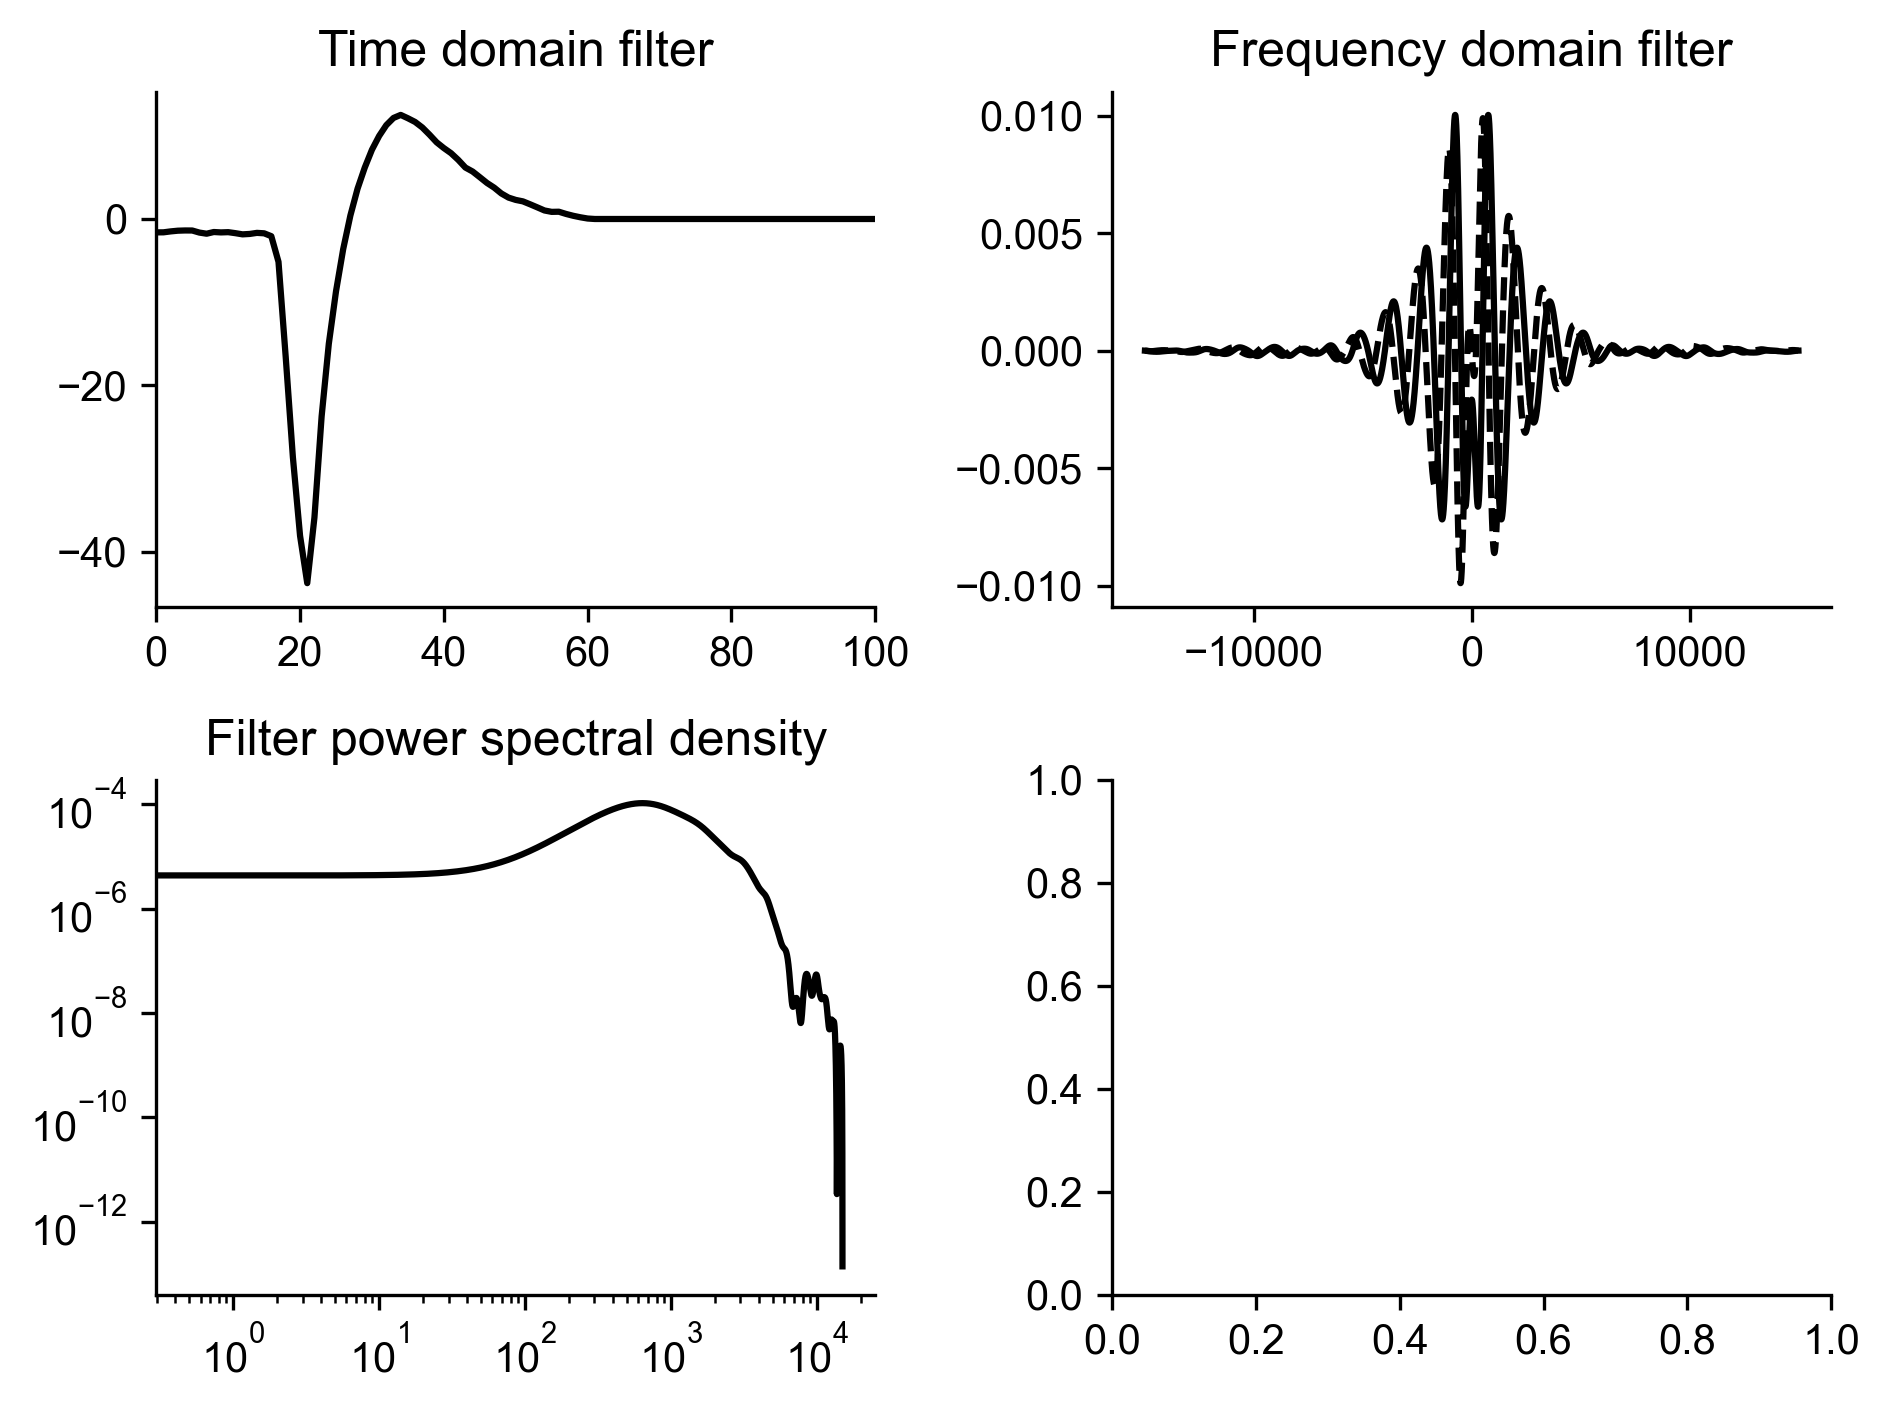

In [38]:
fn.filterfuncs.plot_filters(u21_filters['average_waveform']['time_filter'],
                            u21_filters['average_waveform']['freq_filter'],
                            u21_filters['average_waveform']['filter_psd'], theor_freqs)

Unit 379 filters:

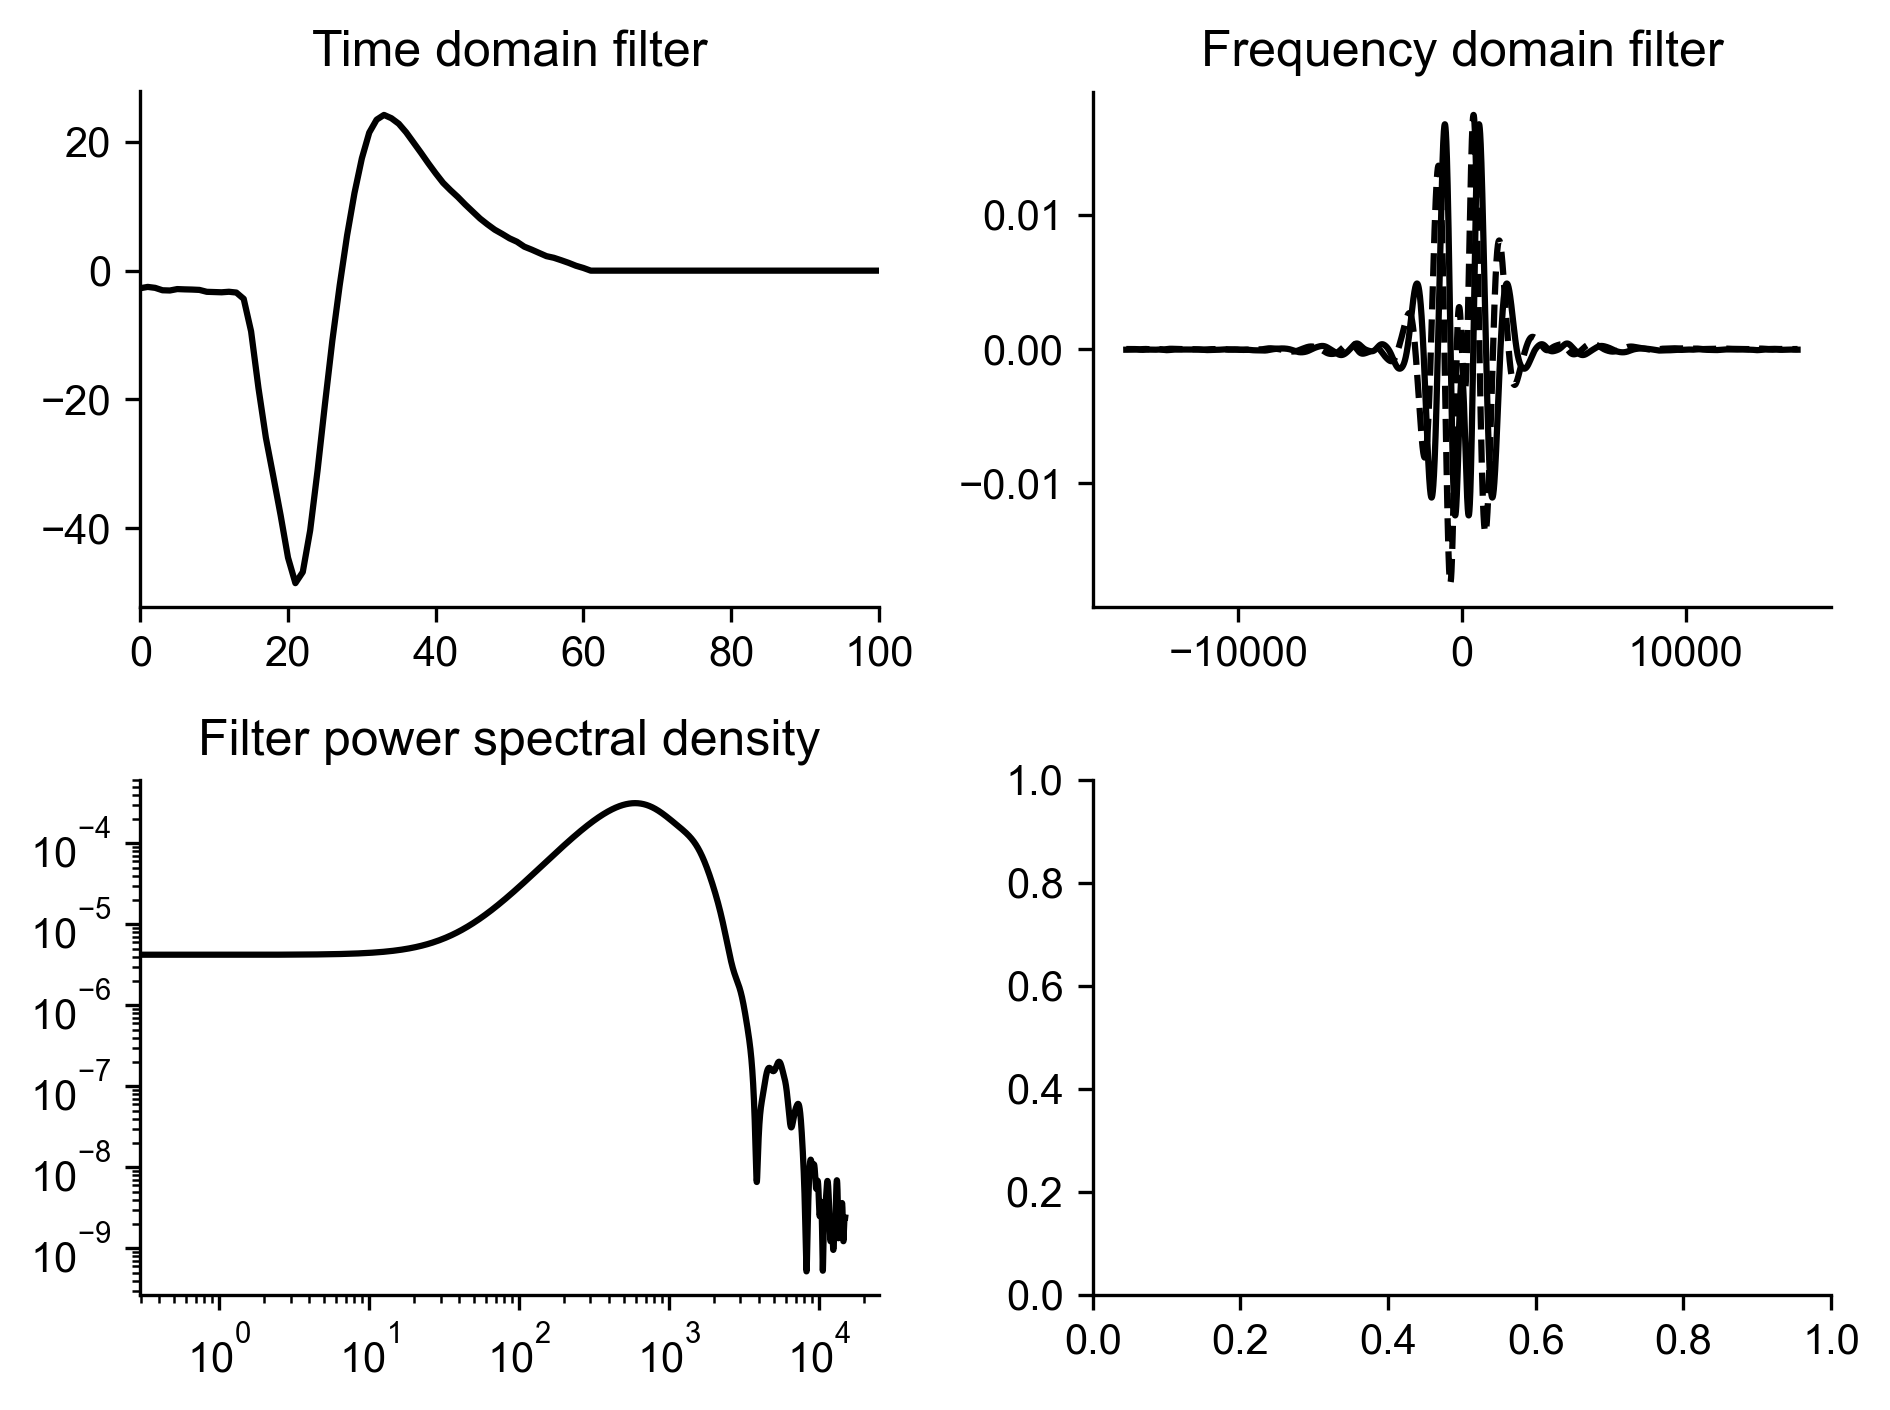

In [39]:
fn.filterfuncs.plot_filters(u379_filters['average_waveform']['time_filter'],
                            u379_filters['average_waveform']['freq_filter'],
                            u379_filters['average_waveform']['filter_psd'], theor_freqs)

We should also look at what kind of averaging to use when obtaining the filters we will work with. We can use the average waveform from the entire recording (waveform-averaged) or we can use the average waveform from the instances within the signal excerpt (the 100-107 seconds, instance-averaged). We can compute the PSD for the waveform-averaged filter, compute the PSD for the instance-averaged filter, or compute the PSD of each instance within the signal excerpt and average afterwards. 

/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


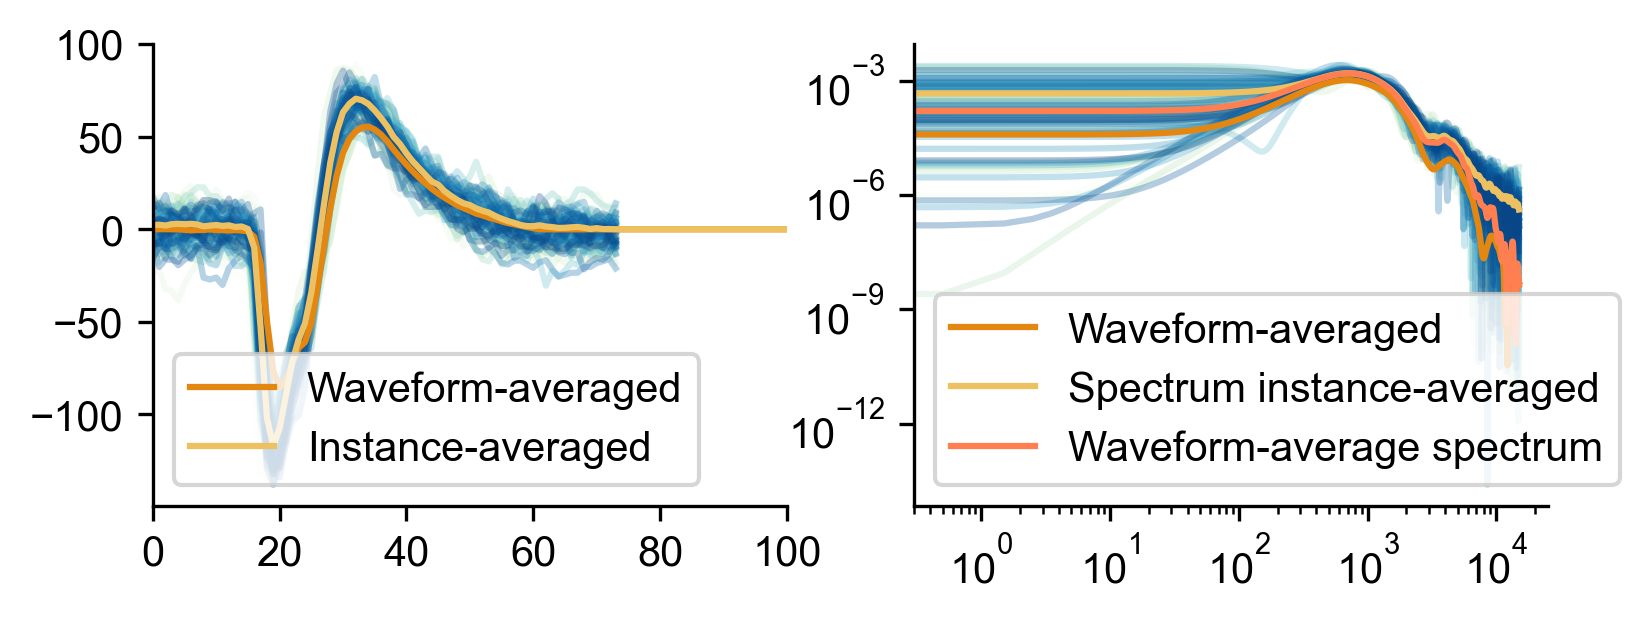

In [40]:
fn.filterfuncs.plot_ia_filters(u296_instances, u296_filters,theor_freqs)

### Waveform analysis

We eventually want to find if cell types with distinct waveforms have different contributiosn to the channel signal power spectrum. Therefore, we shall use WaveMAP (Lee et al. 2021), a nonlinear dimensionality reduction method for detecting waveform clusters, to distinguish putative cell types.

In [41]:
# takes the average waveform from each unit
mean_unit_waveforms = np.array(signal_dataset["waveform_info"]["waveforms"]).mean(axis=2)
mean_unit_waveforms.shape

(138, 62)

These are the average waveforms for each unit:

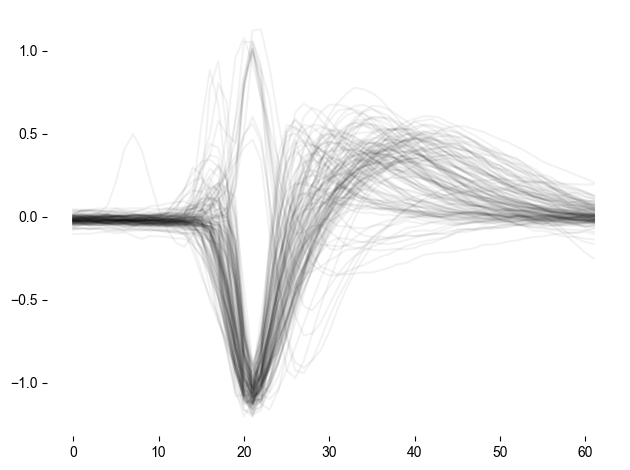

In [42]:
wmc = WaveMAPClassifier(mean_unit_waveforms)
wmc.plot_waveforms()

Now we will apply WaveMAP to the waveforms. This primarily consists of computing dimensionality reduction with UMAP and applying the Louvain method for detecting communities, which will become clusters of waveform types. Note: the backend currently uses a fixed seed for random initialization in the UMAP, ensuring reproducability.

In [43]:
%%time
wmc.compute_waveform_umap()
wmc.apply_louvain_method()

Computing UMAP: 15 neighbors | 0.1 minimum distance | random state 42


/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP computed!
Applying Louvain method: 1.5 resolution
9 clusters detected.
CPU times: user 9.24 s, sys: 390 ms, total: 9.63 s
Wall time: 11.2 s


/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/Users/mateouma/Documents/Research/Stephen Group/fppnpx/fpp-npx/wavemapnpx/WaveMAPClassifier.py:187: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


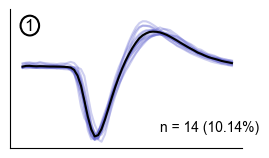

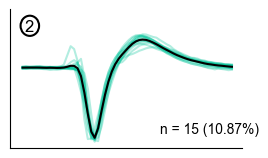

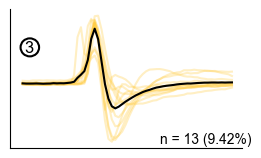

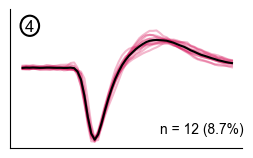

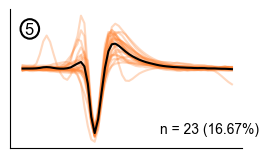

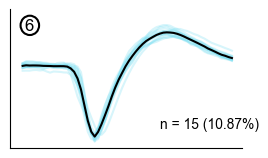

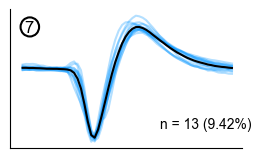

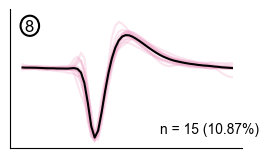

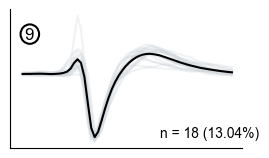

In [44]:
wmc.plot_groups()

In [45]:
wavemap_cluster_labels = np.array(wmc.clustering_solution)

We can superimpose the waveforms and their spectra to visualize how distinguishable they are.

In [46]:
def extract_mean_kernels(labels, groups_df, n, fs):
    time_kernel_means = []
    frequency_kernel_means = []
    kernel_psd_means = []
    kernel_psd_ATKs = []

    for label_ix in range(1, 9+1):
        group_ixs = [i for i,x in enumerate(labels) if x == label_ix-1]
        group_waveforms = groups_df.iloc[group_ixs]['waveform'].tolist()

        time_kernels = []
        frequency_kernels = []
        kernel_psds = []    
        kernel_psds_ATK = []

        for waveform in group_waveforms:
            kernel_t,kernel_f,kernel_psd,freq_axis = fn.filterfuncs.gen_filter(waveform, n, fs, center=True)
            time_kernels.append(kernel_t)
            frequency_kernels.append(kernel_f)
            kernel_psds.append(kernel_psd)
        
        time_kernel_mean = np.array(time_kernels).mean(axis=0)
        freq_kernel_mean = np.array(frequency_kernels).mean(axis=0)
        kernel_psd_mean = np.array(kernel_psds).mean(axis=0)

        _, __,kernel_psd_ATK,___ = fn.filterfuncs.gen_filter(time_kernel_mean, n, fs, center=True)
        
        time_kernel_means.append(time_kernel_mean)
        frequency_kernel_means.append(freq_kernel_mean)
        kernel_psd_means.append(kernel_psd_mean)
        kernel_psd_ATKs.append(kernel_psd_ATK)

    mean_kernels = {
        "time_kernels":np.array(time_kernel_means),
        "freq_kernels": np.array(frequency_kernel_means),
        "kernel_psds": np.array(kernel_psd_means),
        "kernel_psds_ATK": np.array(kernel_psd_ATKs)
    }

    return mean_kernels, freq_axis

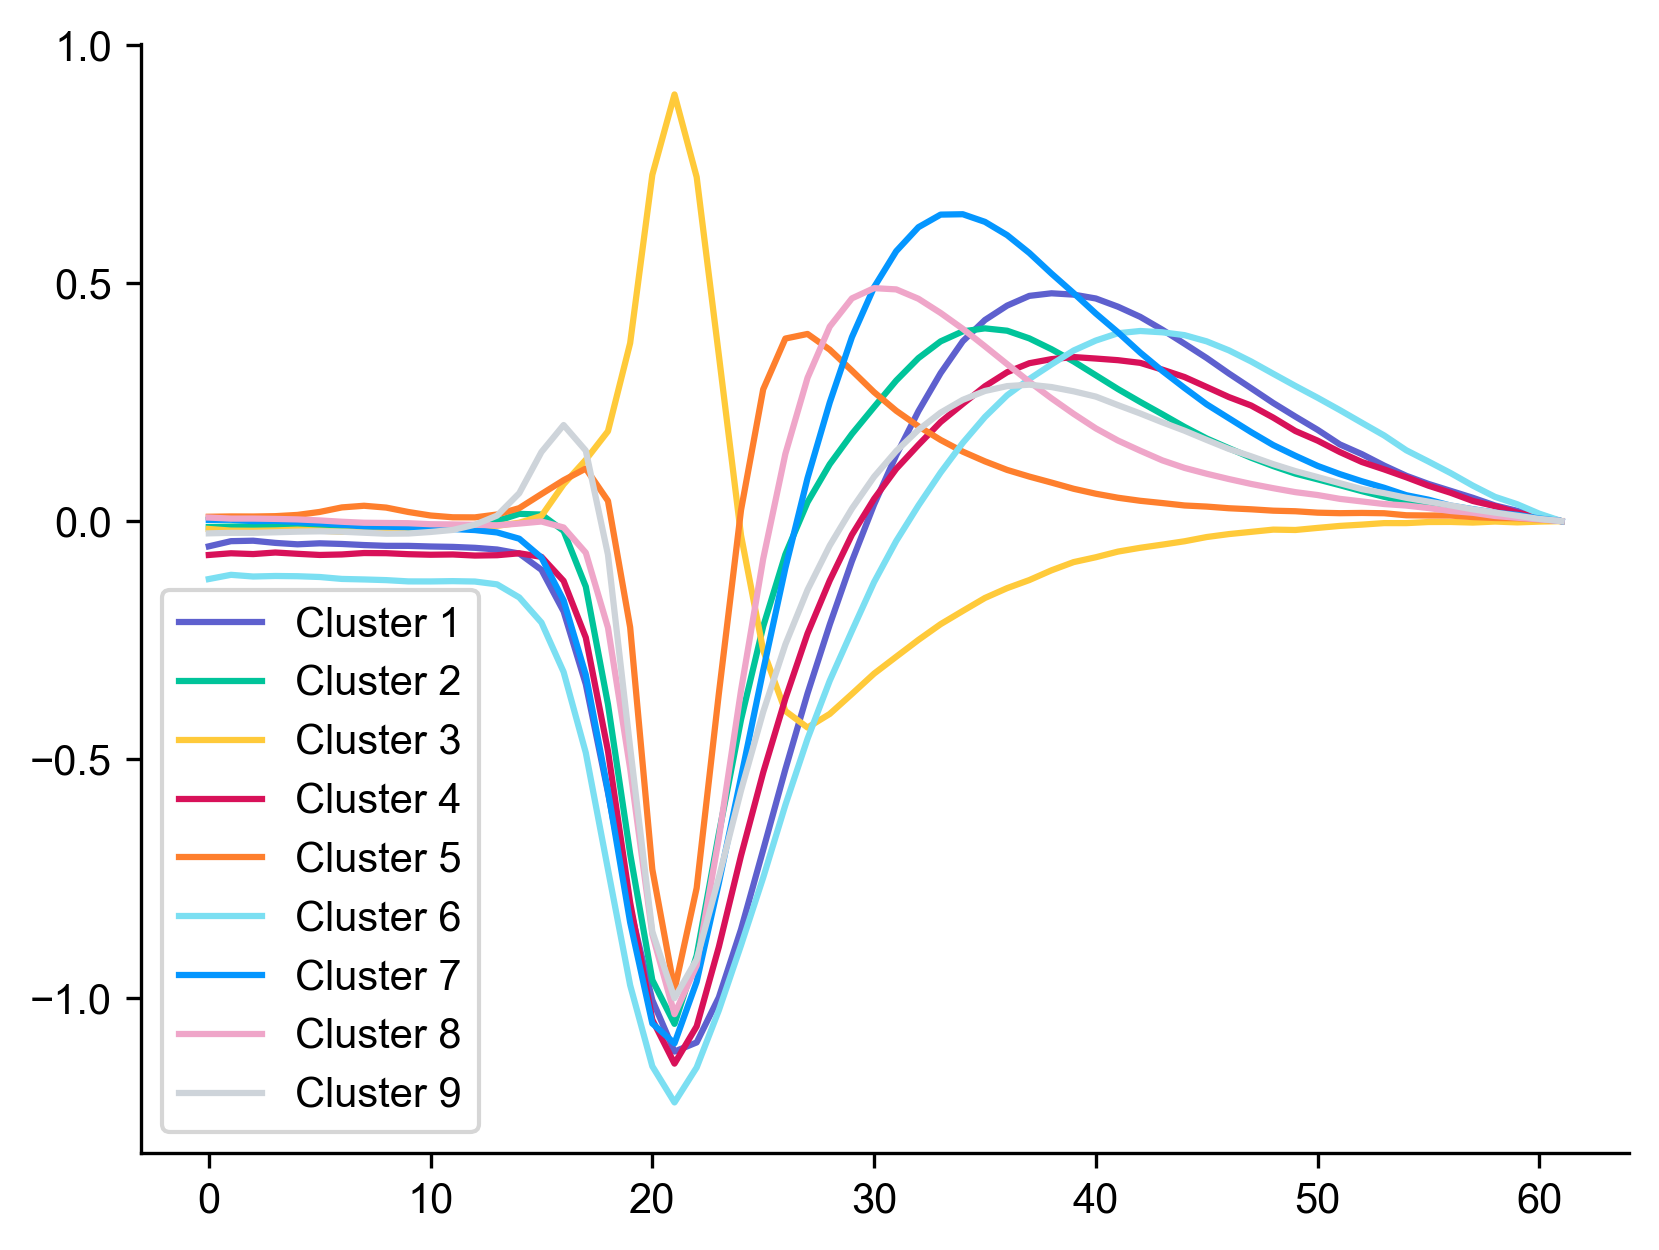

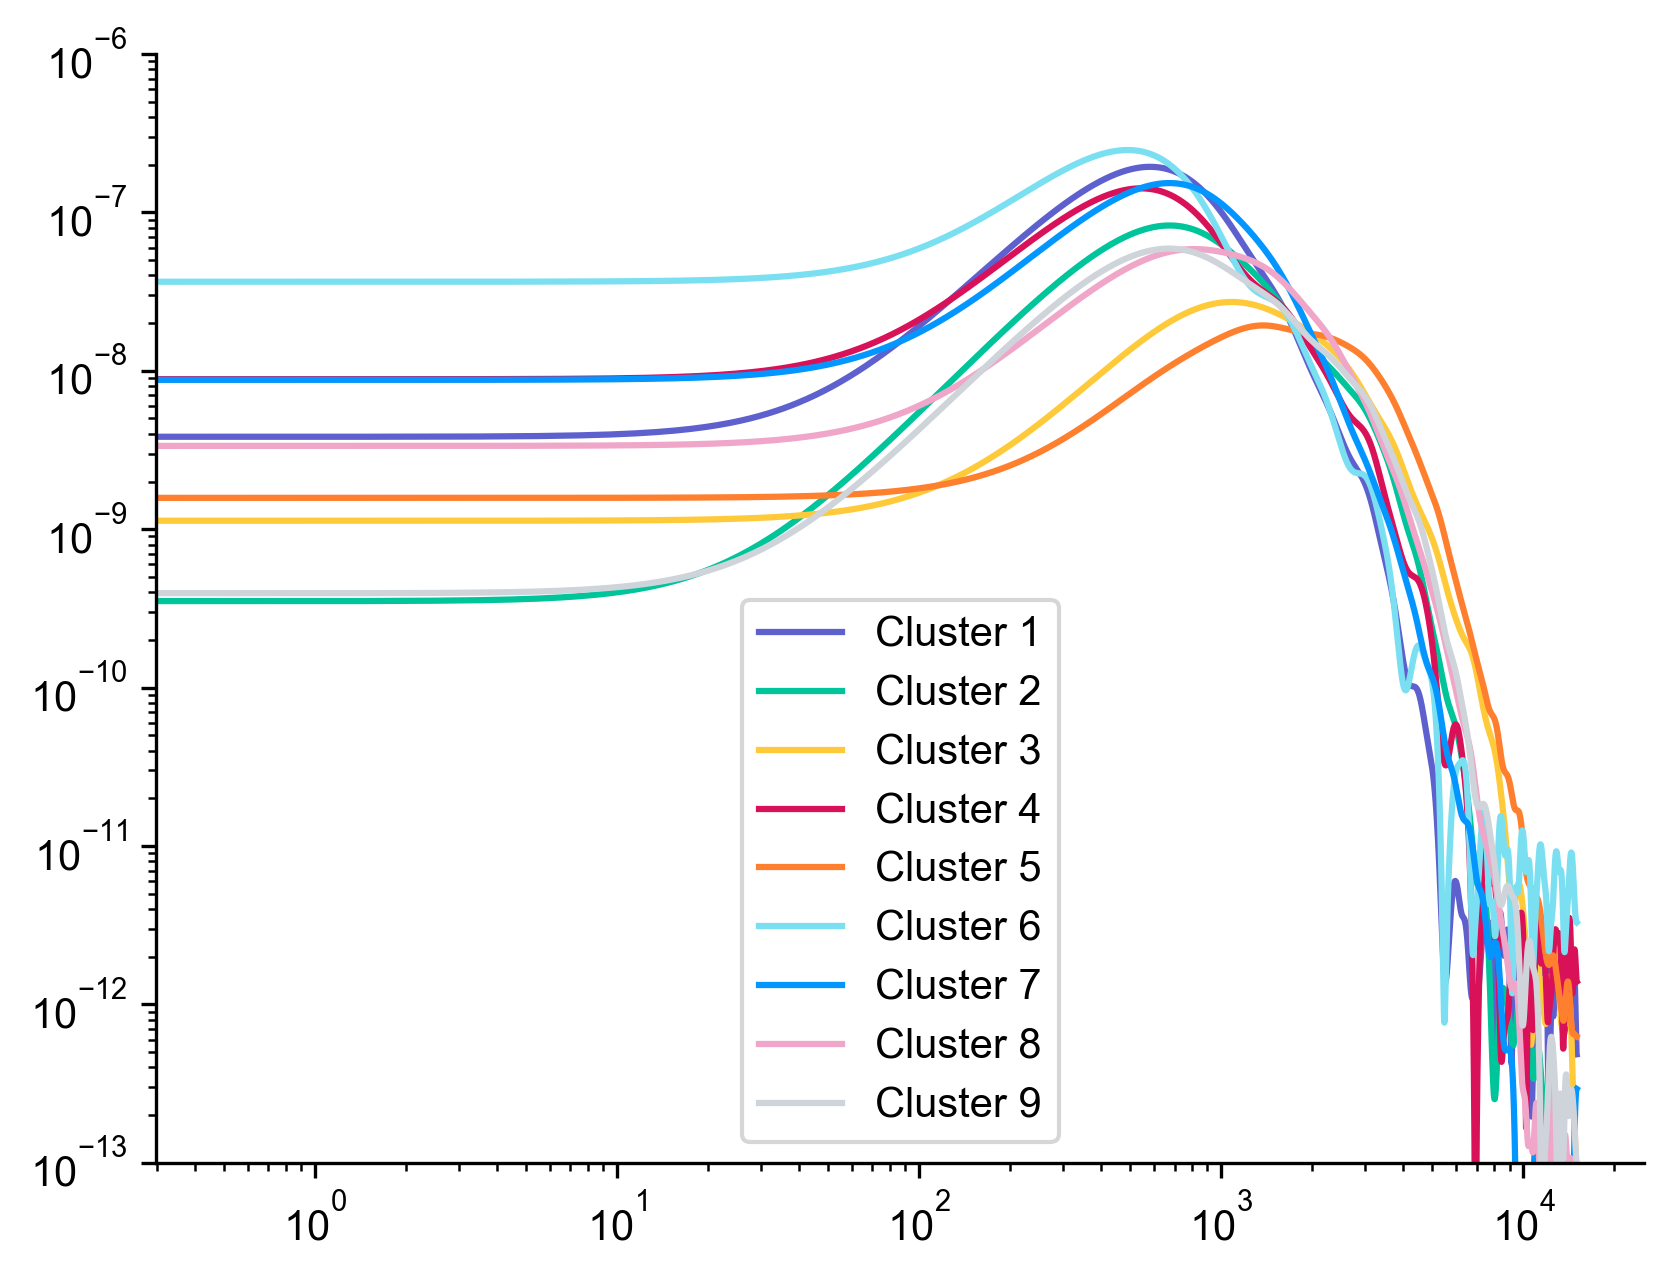

In [47]:
wavemap_kernels, wm_freq_axis = extract_mean_kernels(wavemap_cluster_labels, wmc.umap_df, fs, fs)
plt.figure(dpi=300)
for i in range(9):
    plt.plot(wavemap_kernels['time_kernels'][i,:62], color=CUSTOM_PAL_SORT_3[i], label=f'Cluster {i+1}')
plt.legend()
plt.show()

plt.figure(dpi=300)
for clust_idx in range(9):
    plt.loglog(wm_freq_axis, wavemap_kernels['kernel_psds_ATK'][clust_idx], label=f"Cluster {clust_idx+1}", color=CUSTOM_PAL_SORT_3[clust_idx])
plt.legend()
plt.ylim((1e-13,1e-6))
plt.show()

We want to see if firing rate for different cell types can be decoded from the power spectrum. Therefore, we can see if along the entire probe, different cell types have distinguishable firing rates.

In [49]:
unit_firing_rates = {}

for chan in signal_dataset['channel_unit_index']:
    for u in signal_dataset['channel_unit_index'][chan]:
        unit_firing_rates[u] = channel_signals[f'ch{chan}'].firing_rates[u]

unit_wavemap_label_dict = {}
wavemap_cluster_FRs = []

for i in range(9):
    cluster_i_FRs = []
    for clust_unit in signal_dataset['units'][np.where(wavemap_cluster_labels == i)]:
        unit_wavemap_label_dict[clust_unit] = i
        if unit_firing_rates[clust_unit] > 0:
            cluster_i_FRs.append(unit_firing_rates[clust_unit])
    wavemap_cluster_FRs.append(cluster_i_FRs)

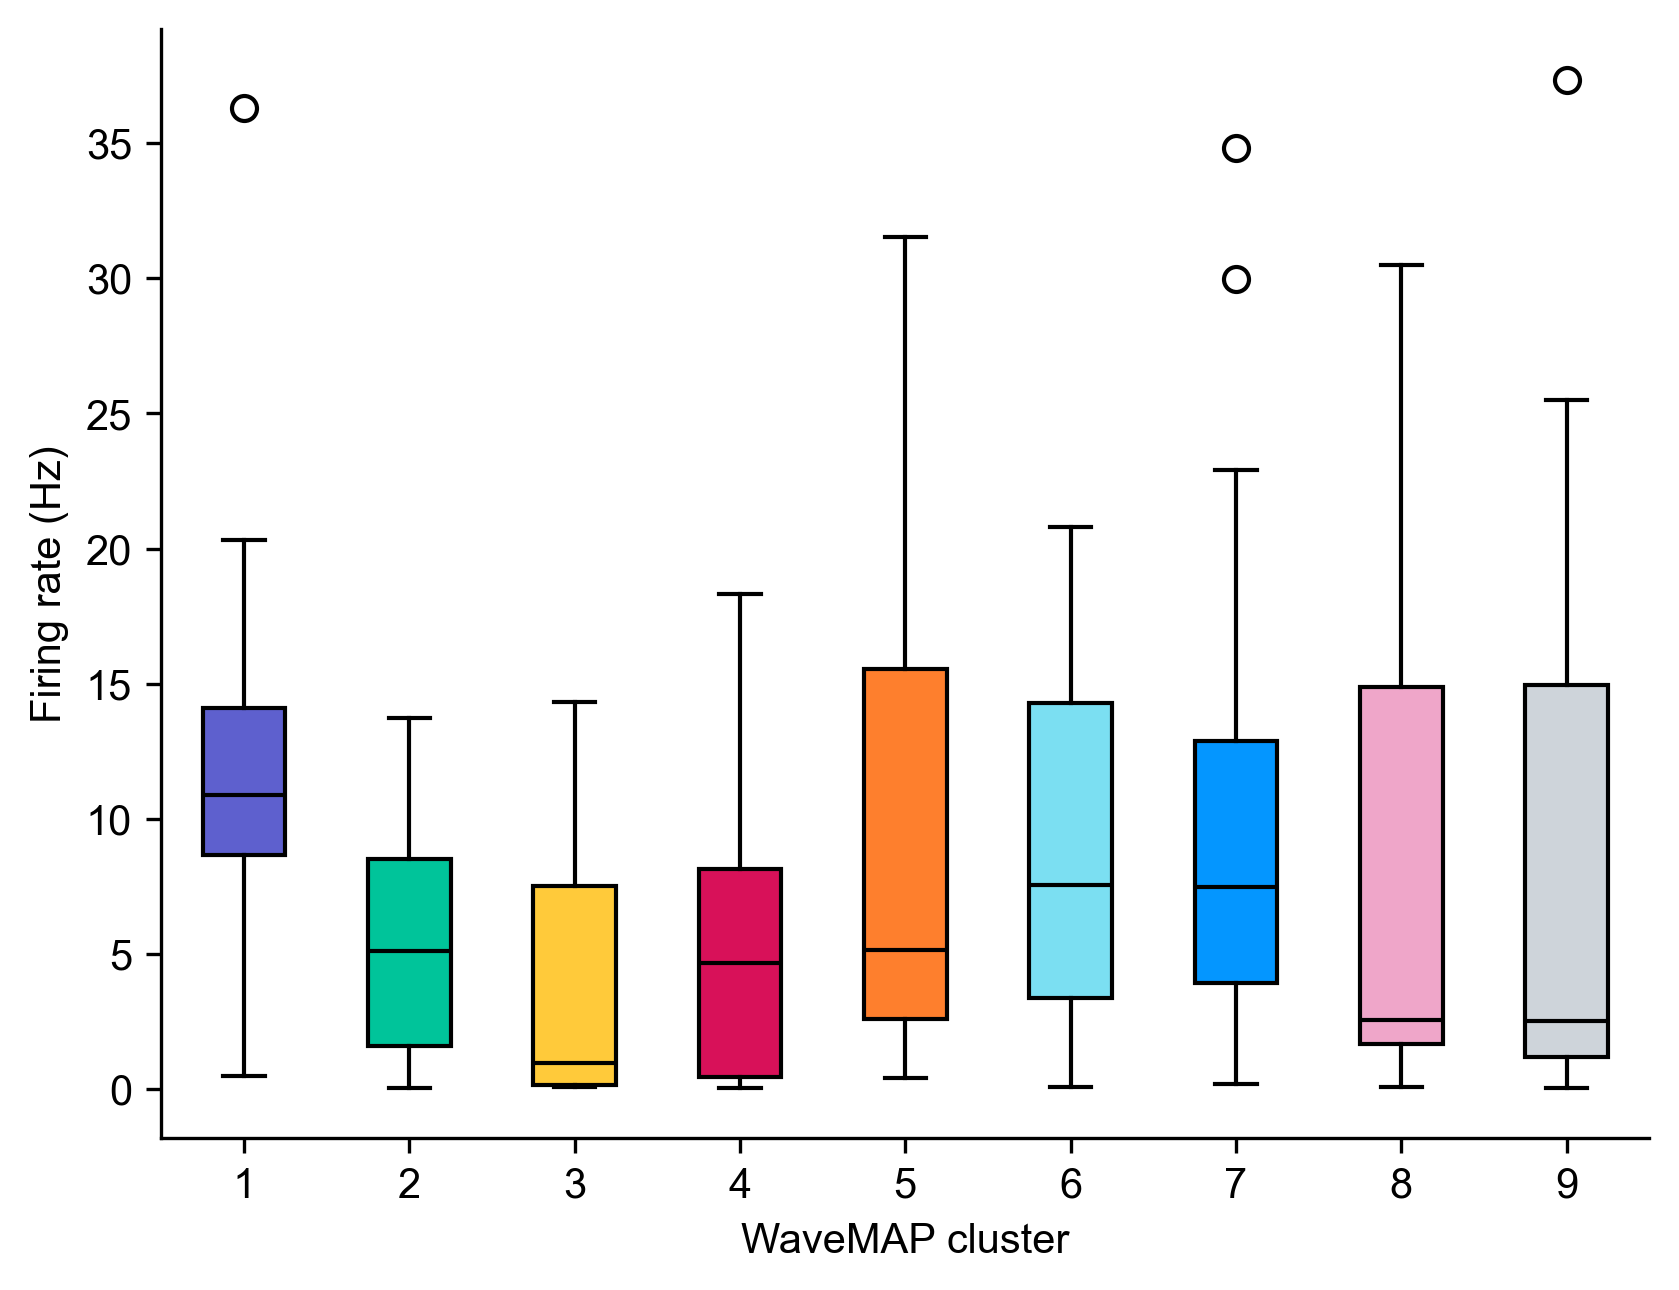

In [50]:
fig, ax = plt.subplots(dpi=300)

bplot = ax.boxplot(wavemap_cluster_FRs,
                   patch_artist=True, # fill with color
                   medianprops={'color': 'k'})

# fill with colors
for patch, color in zip(bplot['boxes'], CUSTOM_PAL_SORT_3[:-1]):
    patch.set_facecolor(color)

plt.xlabel("WaveMAP cluster")
plt.ylabel("Firing rate (Hz)")
plt.show()

We can also see how the firing rates of these clusters and of all of the units evolve throughout time.

In [53]:
from numpy.lib.stride_tricks import sliding_window_view

In [35]:
Nt = channel_signals["ch13"].time_axis.size # number of time points
Nu = signal_dataset['units'].size # number of units

spike_trains_unsorted = np.zeros((Nt, Nu))
units_unsorted = []

u_idx = 0
for ch,ch_sig in channel_signals.items():
    for u, spktimes in ch_sig.spike_times.items():
        spike_trains_unsorted[spktimes.astype(int),u_idx] = 1
        units_unsorted.append(u)
        u_idx += 1

spike_trains = spike_trains_unsorted[:,np.argsort(units_unsorted)]

In [36]:
cluster_mean_firing_rates = []
cluster_ste_firing_rates = []

tstep_sec = 0.5 # 500 ms step
twin_sec = 1 # 1 s window length
fr_t = np.arange(time_window[0], time_window[1]-tstep_sec, tstep_sec)
tstep = int(tstep_sec * fs) # 500 ms step
twindow = int(twin_sec * fs) # 1 s window length

for cl in range(9):
    cluster_spk_trains = spike_trains[:,np.where(wavemap_cluster_labels == cl)[0]] # which spike trains correspond to cluster 'cl'

    windowed_spk_trains = sliding_window_view(cluster_spk_trains, window_shape=twindow, axis=0) # group spikes in twindow size windows

    firing_rates = windowed_spk_trains[::tstep].sum(axis=2) / twin_sec # slide by tstep and average the spikes in each window

    mean_firing_rate = firing_rates.mean(axis=1) # averaged across all of the units under this cluster
    ste_firing_rate = firing_rates.std(axis=1) / np.sqrt(firing_rates.shape[1])

    cluster_mean_firing_rates.append(mean_firing_rate)
    cluster_ste_firing_rates.append(ste_firing_rate)

cluster_mean_firing_rates = np.array(cluster_mean_firing_rates)
cluster_ste_firing_rates = np.array(cluster_ste_firing_rates)

NameError: name 'wavemap_cluster_labels' is not defined

In [39]:
windowed_pop_spk_trains = sliding_window_view(spike_trains, window_shape=twindow, axis=0)
pop_firing_rates = windowed_pop_spk_trains[::tstep].sum(axis=2) / twin_sec
mean_pop_firing_rate = pop_firing_rates.mean(axis=1)
ste_pop_firing_rate = pop_firing_rates.std(axis=1) / np.sqrt(pop_firing_rates.shape[1])

In [37]:
plt.figure(figsize=(8,4), dpi=300)
for cl in range(9):
    plt.plot(fr_t, cluster_mean_firing_rates[cl], color=CUSTOM_PAL_SORT_3[cl], label=f'Cluster {cl+1}')
    plt.fill_between(fr_t, cluster_mean_firing_rates[cl]-cluster_ste_firing_rates[cl], cluster_mean_firing_rates[cl]+cluster_ste_firing_rates[cl],
                     color=CUSTOM_PAL_SORT_3[cl], alpha=0.5)
plt.plot(fr_t, mean_pop_firing_rate, color='k', label='Population Avg.')
# plt.fill_between(fr_t, mean_pop_firing_rate-ste_pop_firing_rate, mean_pop_firing_rate+ste_pop_firing_rate,
#                  color='k', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Firing rate (Hz)")
# plt.xlim((100,106))
plt.legend()
plt.show()

IndexError: list index out of range

<Figure size 2400x1200 with 0 Axes>

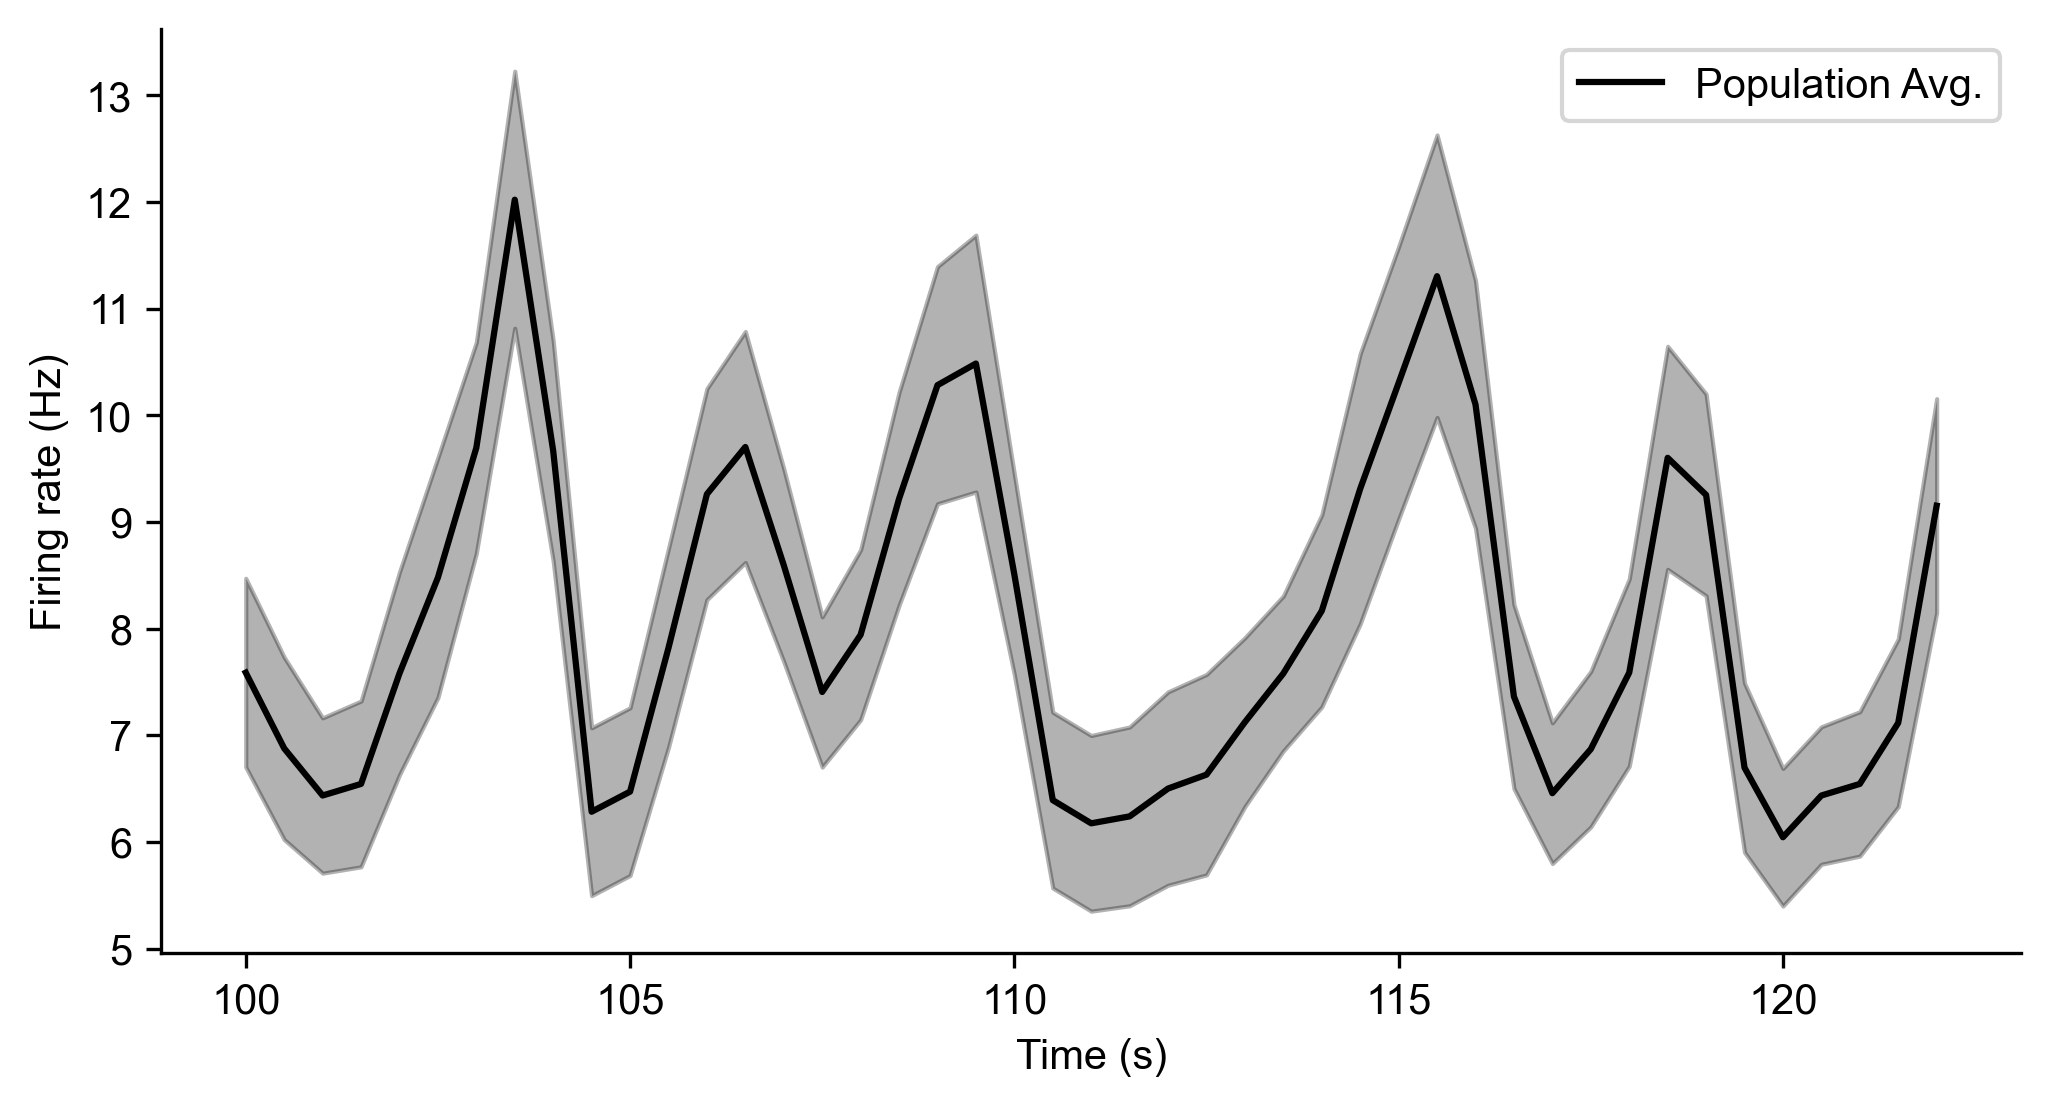

In [64]:
plt.figure(figsize=(8,4), dpi=300)
plt.plot(fr_t, mean_pop_firing_rate, color='k', label='Population Avg.')
plt.fill_between(fr_t, mean_pop_firing_rate-ste_pop_firing_rate, mean_pop_firing_rate+ste_pop_firing_rate,
                 color='k', alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Firing rate (Hz)")
# plt.xlim((100,106))
plt.legend()
plt.show()

## Initial model

### FPP-GLM

We will see if we can use the filtered point process forward model to infer a spiking unit's contribution to the power spectrum. Under the FPP framework, the recorded signal can be described as

$$
Y^{\text{channel}}(t) = \sum_p X^{p}\circledast h^{p}(t)
$$

where $p$ is a process, $X$ is the point process, and $h$ is the filter. We hypothesize that the dominant contribution to the power spectrum is the spiking of a unit. Under this reasoning,

$$
Y^{\text{channel}}(t) \approx Y^{\text{unit}}=X^{\text{unit}}\circledast h^{\text{unit}}(t).
$$

Thus, the spectrum of the channel signal would be

$$
S_Y^{\text{channel}}(\omega)\approx S^{\text{unit}}_Y(\omega)=S^{\text{unit}}_X| \cdot \mathcal{H}(\omega)|^2.
$$

If we assume $X$ to be a homogeneous Poisson process with rate $\lambda_0$, its spectrum would also be $\lambda_0$. 

$$
S_Y^{\text{channel}}(\omega)\approx \lambda_0 \cdot |\mathcal{H}(\omega)|^2
$$

Theoretically, we can use a Gamma generalized linear model of the form $y=X\beta$ to estimate the firing rate parameter $\lambda_0$ where $y$ is the PSD of the channel signal, $X$ is the design matrix containing the filter (spike waveform), and $\beta$ is the rate parameter. To test this hypothesis, we can initially test if this method can decode the firing rate if the signal were only comprised of the individual spikes of a certain unit. The following extracts each observed spike from a unit on the channel. We predict that the multitapered power spectral density estimate follows a Gamma distribution

$$
S_{Y,f}\sim\Gamma(k=\text{No. tapers}, \theta=\frac{S_{Y,f}}{\text{No. tapers}}=\frac{\lambda_0 \cdot S^{\text{unit}}_{X,f}}{\text{No. tapers}})
$$

Where $k$ is the shape parameter 

In [65]:
individual_spk_arr = np.zeros((channel_signals['ch163'].spike_times[296].size, fs*(time_window[1]-time_window[0])))

# this is a pretty inefficient way, it would just be easier to index the signal around each spike time
# but i already wrote this once i realized
for i,spk_time in enumerate(channel_signals['ch163'].spike_times[296]):
    individual_spk_arr[i,spk_time] = 1

    exact_spk_instance = np.convolve(individual_spk_arr[i], u296_instances['waveforms'][i])

    individual_spk_arr[i] = exact_spk_instance[20:-53]

exact_spks = np.sum(individual_spk_arr, axis=0)

Multitaper frequency resolution: 0.2608695652173913
Multitaper number of tapers: 5


/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Theoretical lambda_0:      3.913
Estimated lambda_0:        4.013
Gamma Dispersion (phi):    0.225
Gamma Shape (k):           4.453


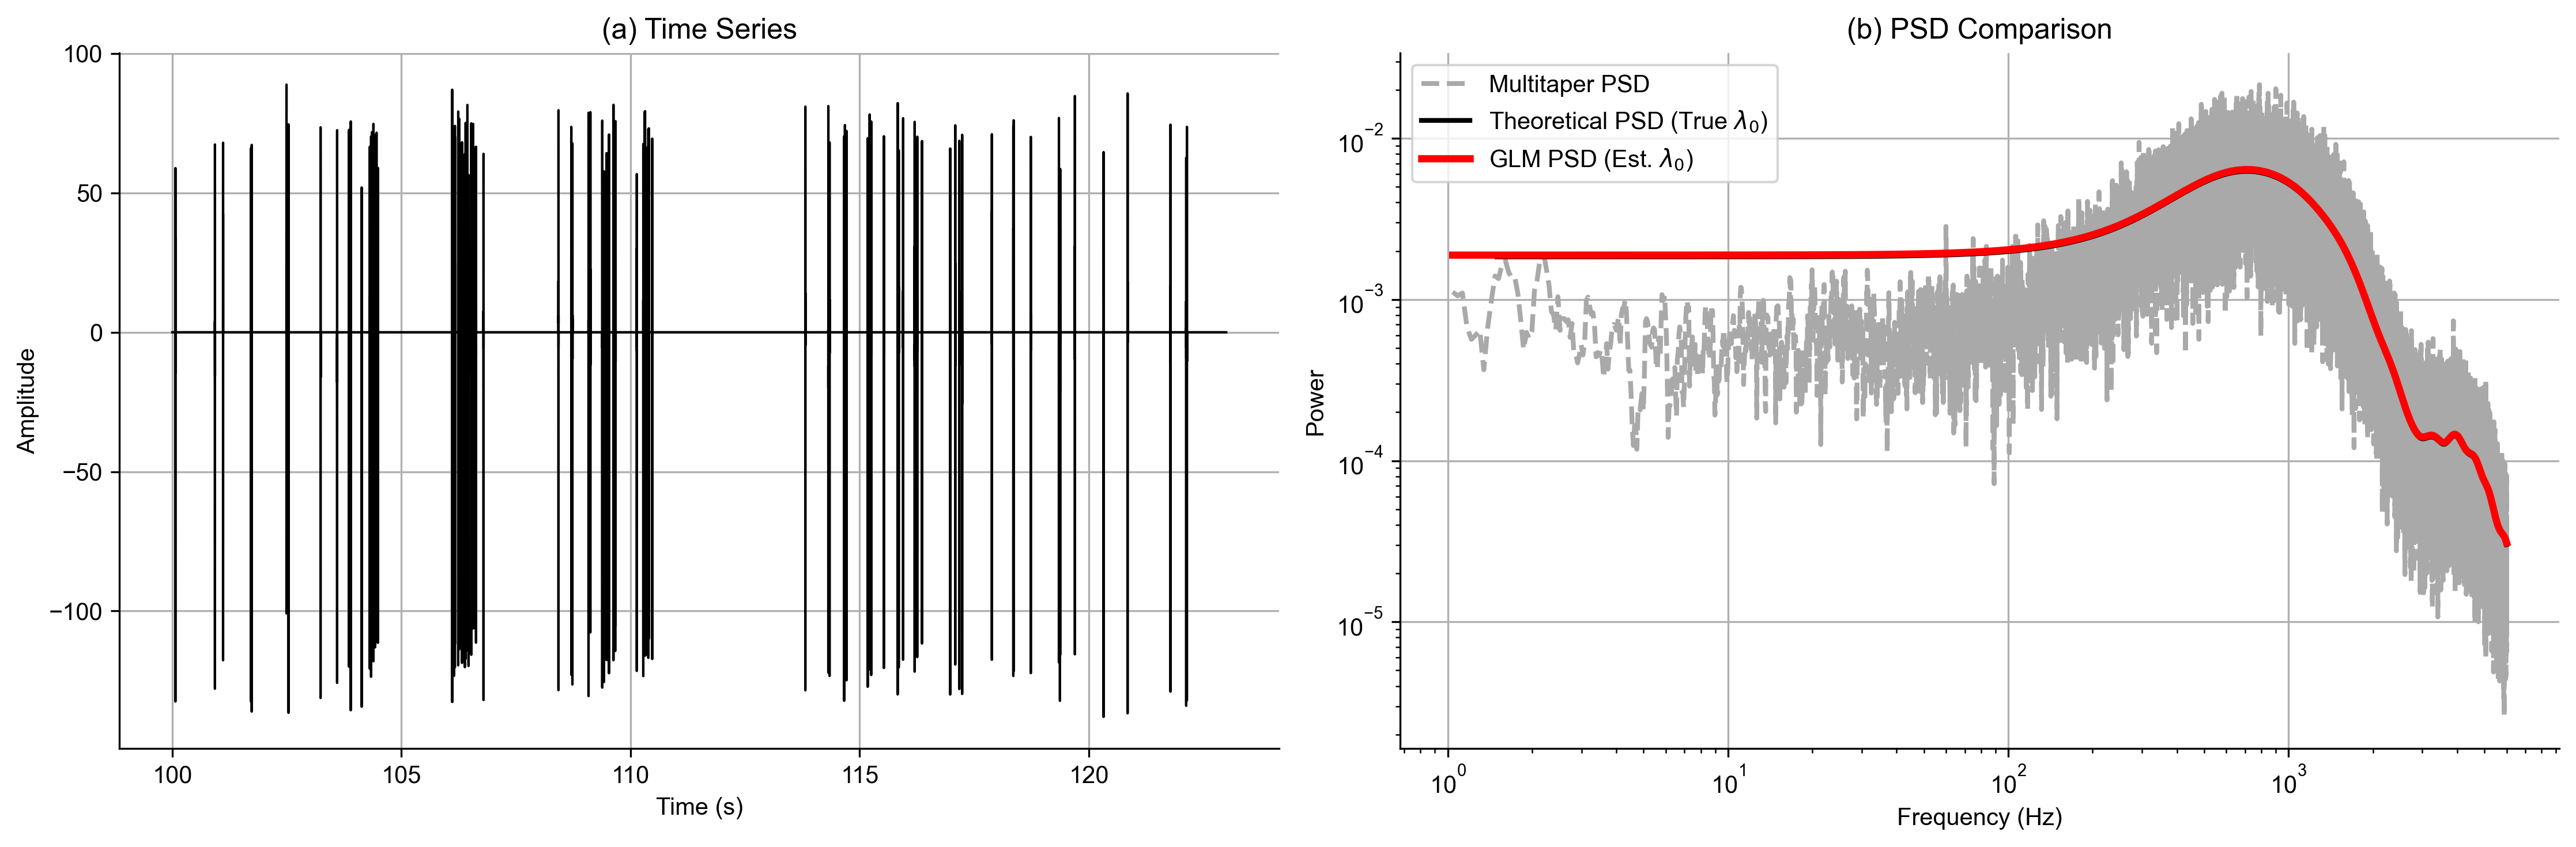

In [261]:
fppglm = FPPGLM(time_series=exact_spks,
                time_axis=channel_signals['ch163'].time_axis,
                fs=channel_signals['ch163'].fs)

obs_firing_rates = np.array([channel_signals['ch163'].firing_rates[296]])

fppglm.fit(filter_psd_list=[u296_filters['waveform_instance']['filter_psd']],
           lambda_observed=obs_firing_rates,
           theoretical_frequencies=theor_freqs, bias=False,
           freq_range=(1,6000))

fppglm.plot_results()

To assess model fit, we will construct a Q-Q plot with the theoretical Gamma distribution. To obtain a Gamma distribution across all frequencies, we will use 

$$
Z_f = \frac{k\cdot \hat{S}_{Y,f}}{S_{y,f}}, 
$$

resulting in a random variable

$$
Z_f\sim \Gamma(k,1)
$$

In [262]:
Z_f = (5 * fppglm.multitaper_psd_truncated) / fppglm.theoretical_psd_interpolated

In [206]:
from scipy.stats import gamma
import statsmodels.api as sm

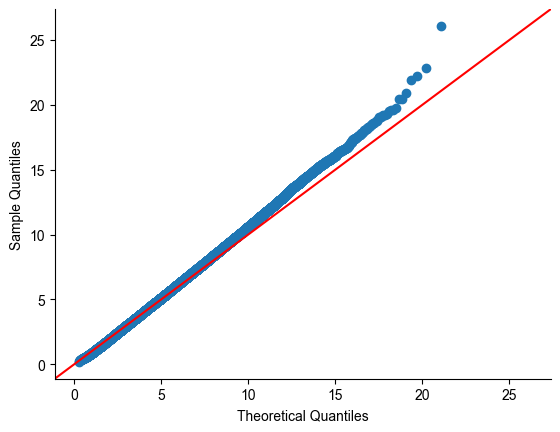

In [265]:
sm.qqplot(Z_f, dist=gamma, distargs=(5,), line='45')
plt.show()

As we can see, a FPP-GLM decoder can estimate the firing rate from a time-series signal containing only the observed spikes. Furthermore, the Q-Q plot agrees nicely with our model. However, when we actually attempt to decode the firing rate from an entire signal, we do not get accurate estimation.

Multitaper frequency resolution: 0.2608695652173913
Multitaper number of tapers: 5


/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Theoretical lambda_0:      3.913
Estimated lambda_0:        36.231
Gamma Dispersion (phi):    60.641
Gamma Shape (k):           0.016


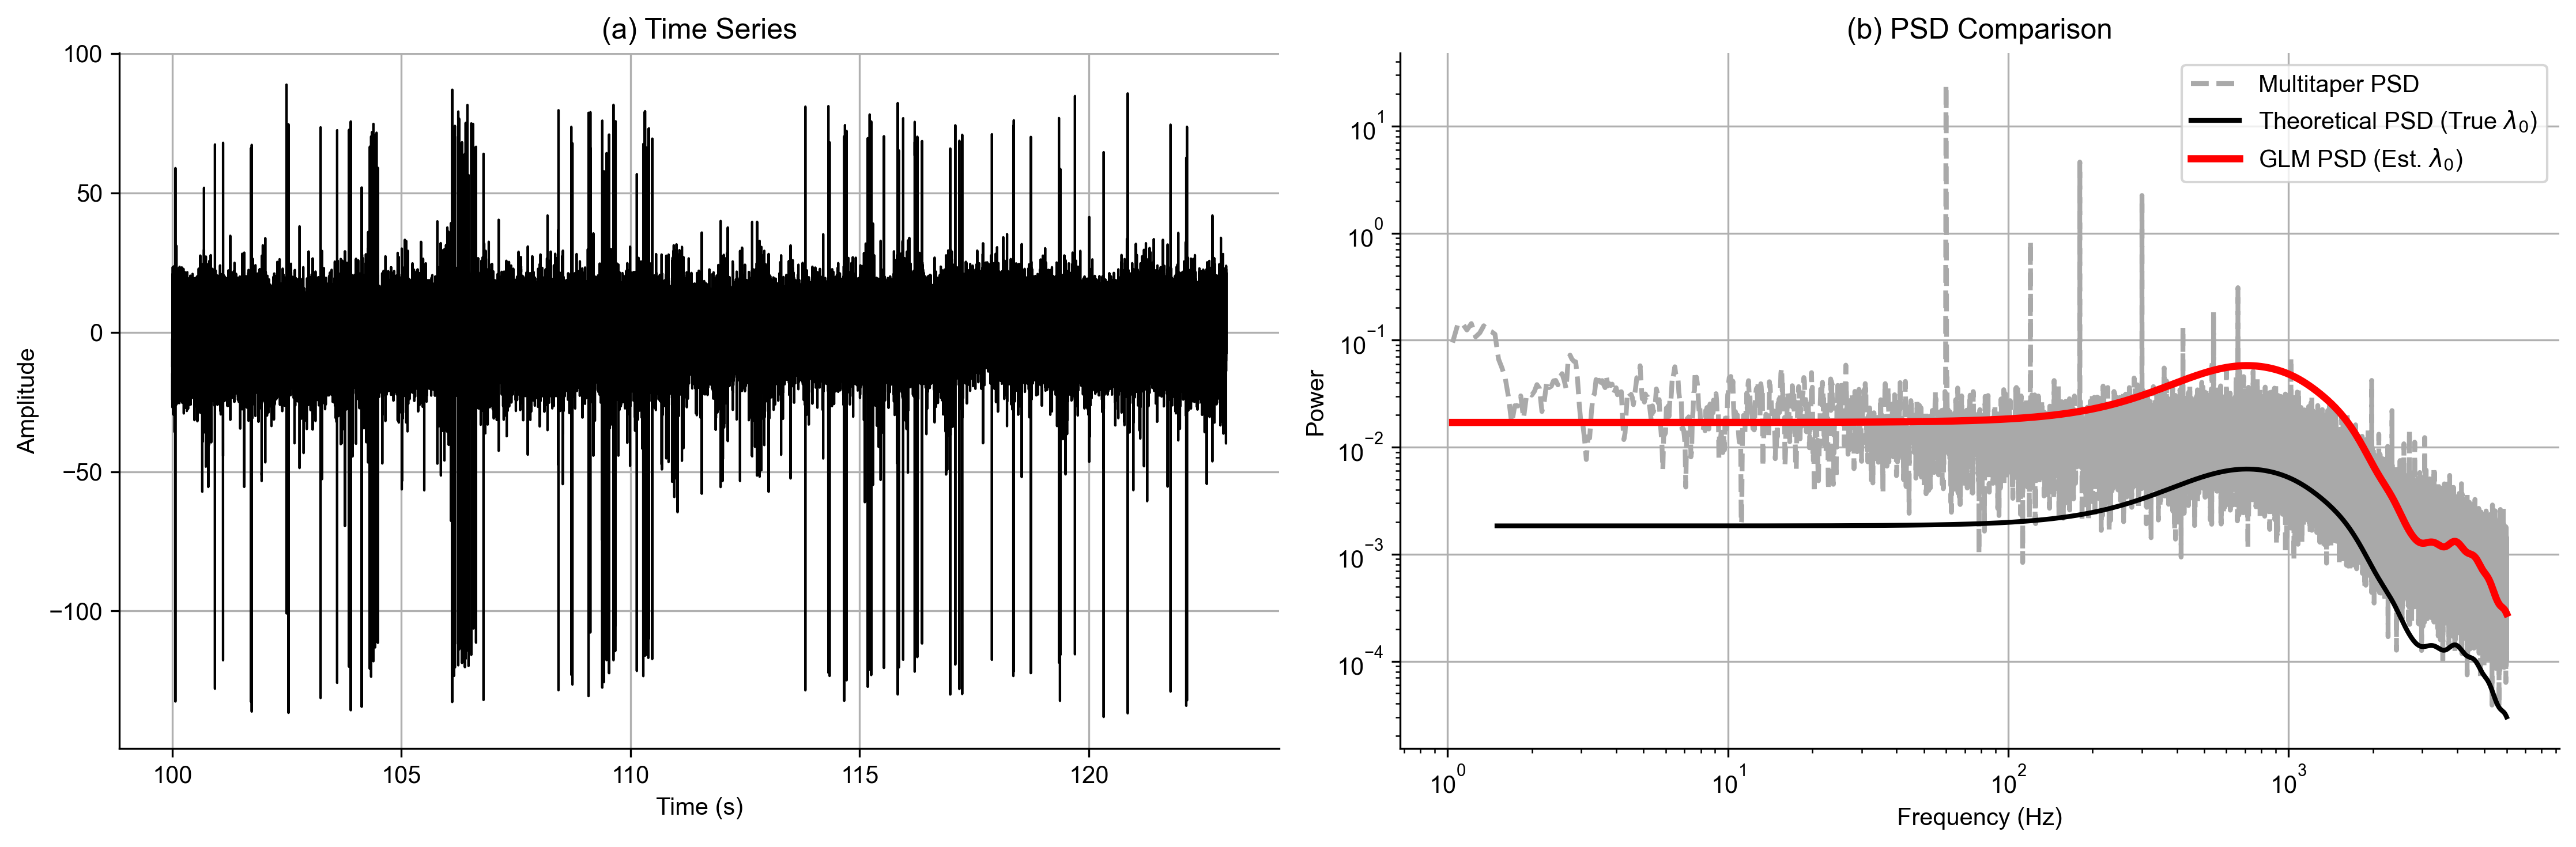

In [266]:
fppglm = FPPGLM(time_series=channel_signals['ch163'].time_series,
                time_axis=channel_signals['ch163'].time_axis,
                fs=channel_signals['ch163'].fs)

obs_firing_rates = np.array([channel_signals['ch163'].firing_rates[296]])

fppglm.fit(filter_psd_list=[u296_filters['waveform_instance']['filter_psd']],
           lambda_observed=obs_firing_rates,
           theoretical_frequencies=theor_freqs, bias=False,
           freq_range=(1,6000))

fppglm.plot_results()

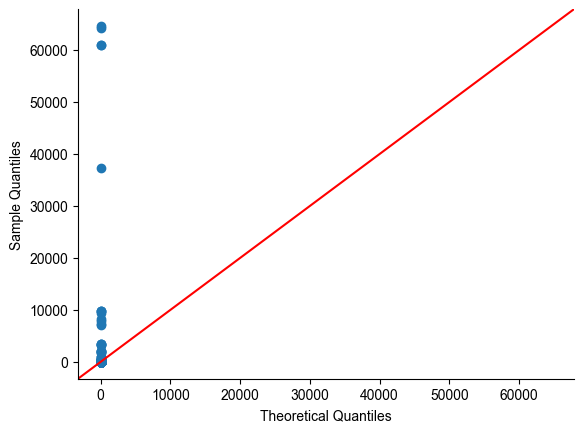

In [267]:
Z_f = (5 * fppglm.multitaper_psd_truncated) / fppglm.theoretical_psd_interpolated

sm.qqplot(Z_f, dist=gamma, distargs=(5,), line='45')
plt.show()

The GLM is overestimating $\lambda_0$ since it is primarily fitting the tail end of the spectrum as we are plotting in log space. The Q-Q plot demonstrates this as the sample quantiles are orders of magnitude larger resulting in a poor fit to the line. We can also try restricting the frequency range to 300-2000 Hz.

/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Theoretical lambda_0:      3.913
Estimated lambda_0:        11.024
Gamma Dispersion (phi):    6.242
Gamma Shape (k):           0.160


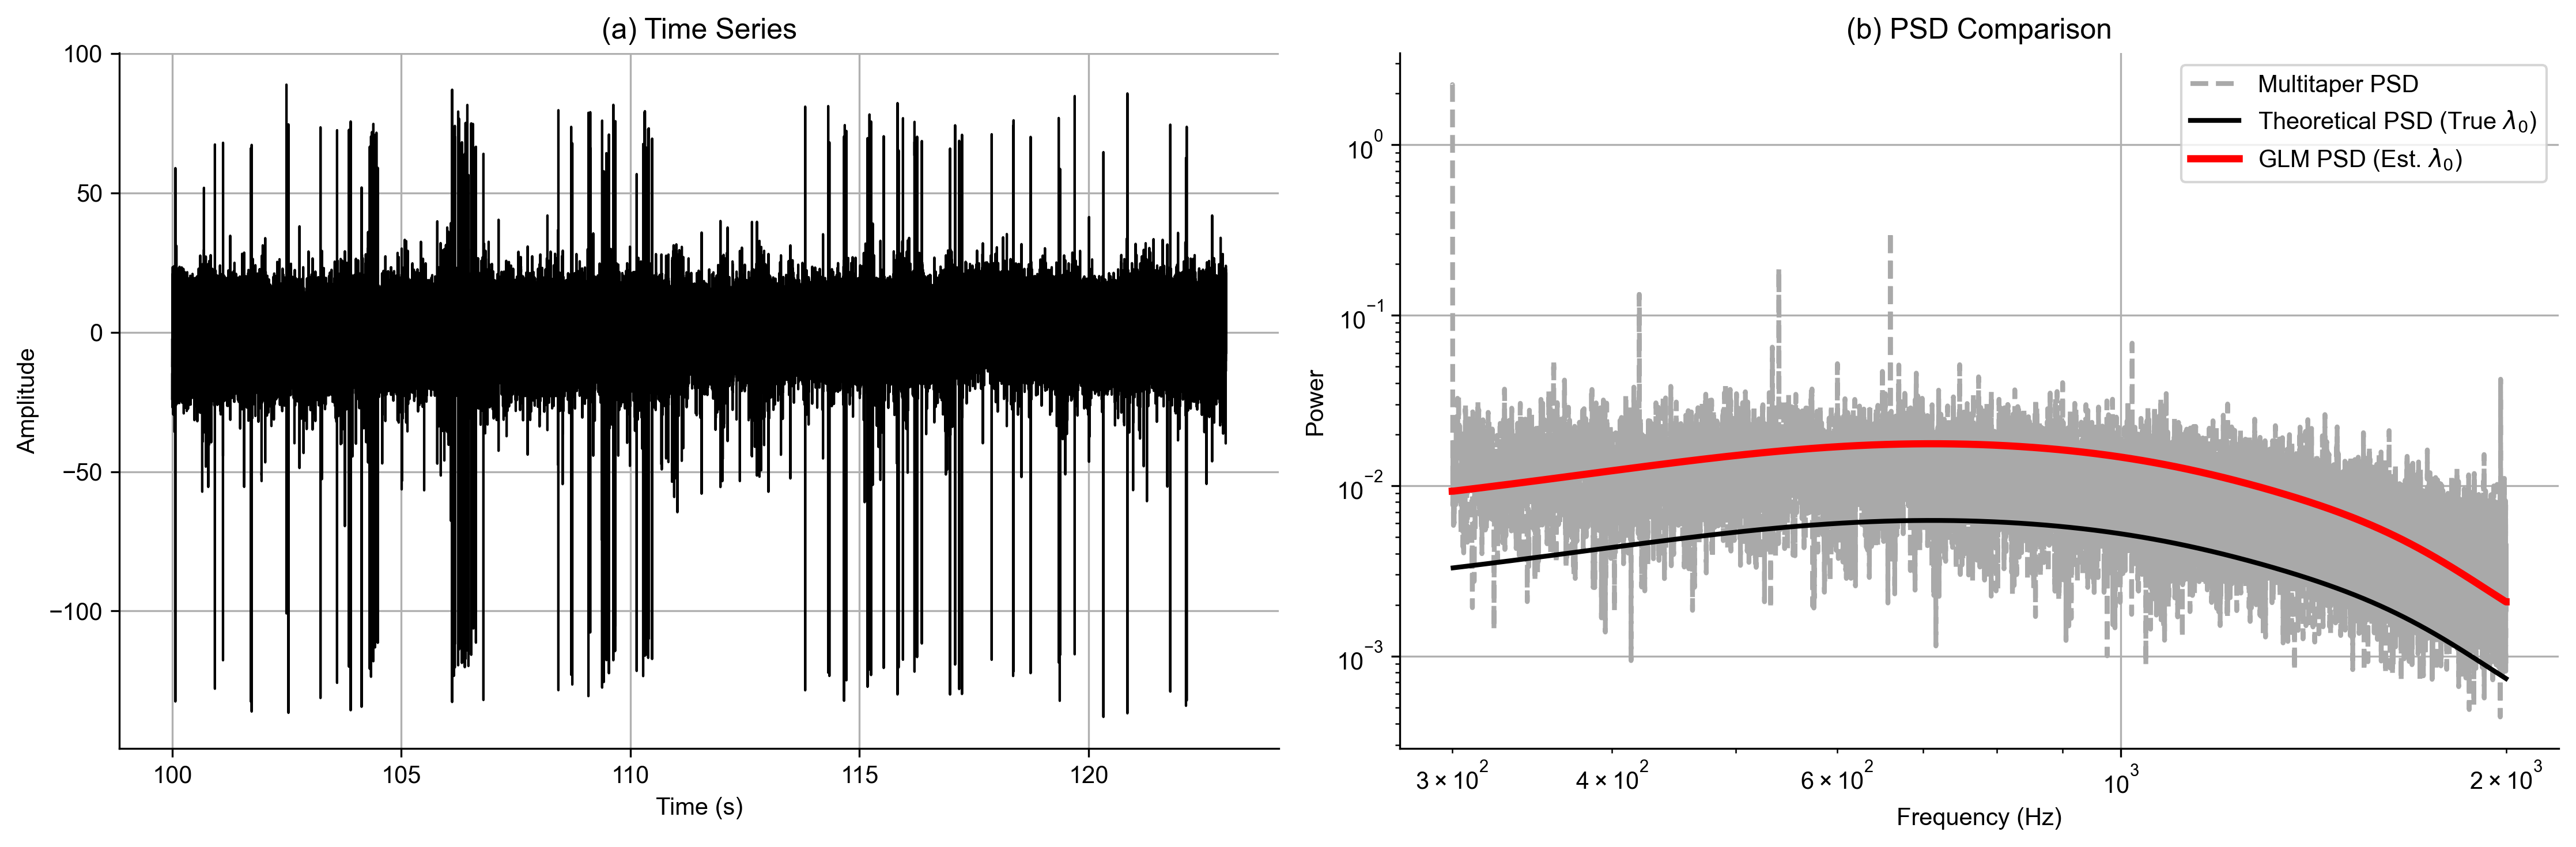

In [268]:
fppglm.fit(filter_psd_list=[u296_filters['waveform_instance']['filter_psd']],
           lambda_observed=obs_firing_rates,
           theoretical_frequencies=theor_freqs, bias=False,
           freq_range=(300,2000))

fppglm.plot_results()

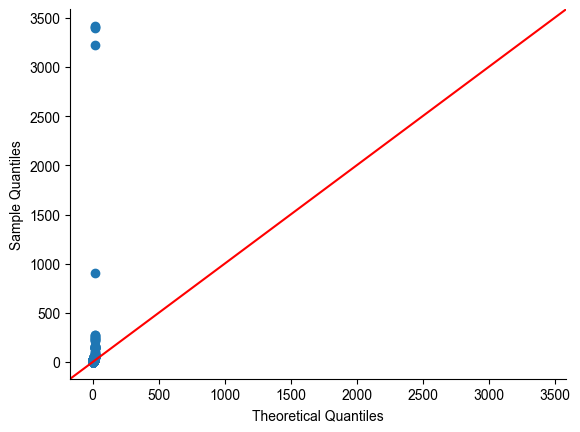

In [270]:
Z_f = (5 * fppglm.multitaper_psd_truncated) / fppglm.theoretical_psd_interpolated

sm.qqplot(Z_f, dist=gamma, distargs=(5,), line='45')
plt.show()

Even after constraining to the spiking band, we can see that the theoretical power spectrum (observed instance-averaged spike waveform PSD multiplied by the empirical $\lambda_0$) does not dominate any range of the spectrum.

### Probing individual unit contributions

We can look at a channel with multiple detected units and see if we can quantify their individual contributions to the power spectrum. To do this, we will calculate the theoretical power spectrum for each of the detected units on channel 208 with $\lambda_0 |\mathcal{H}(\omega)|^2$ where both values are observed. To recall:

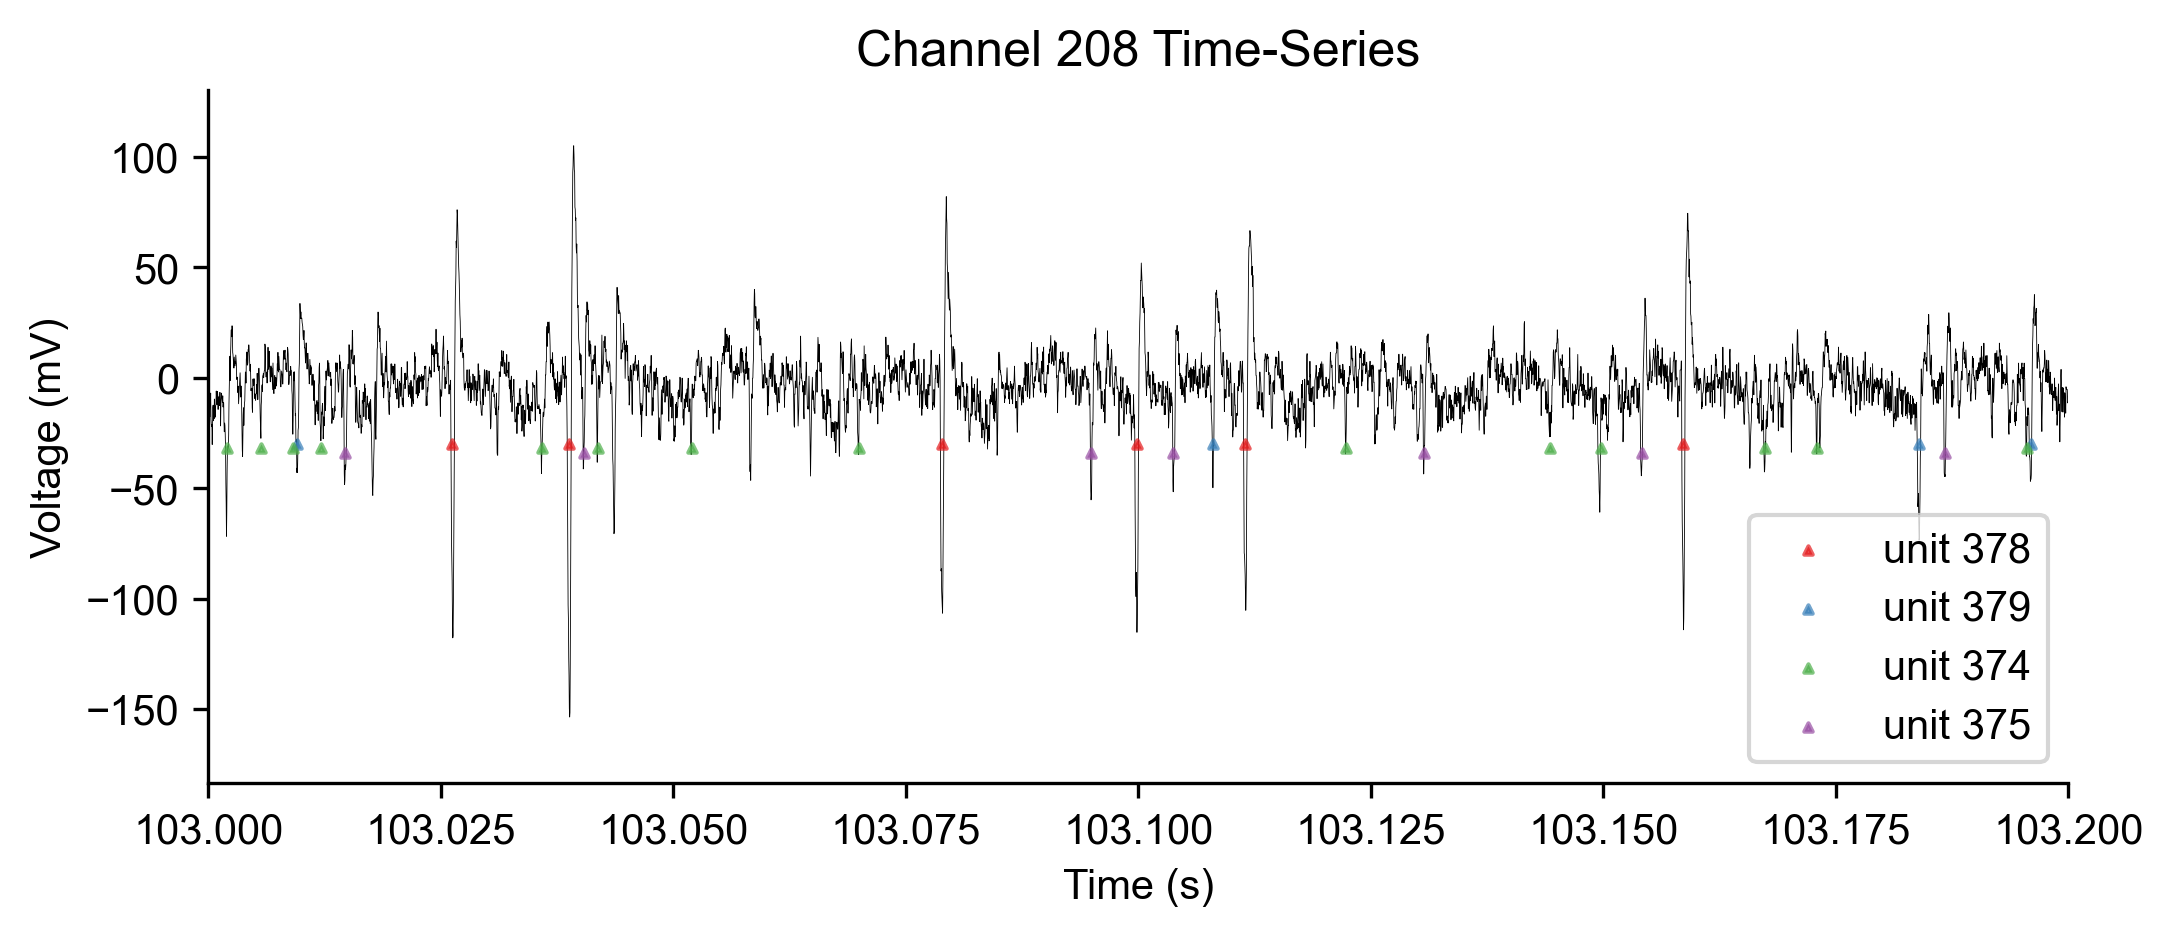

In [72]:
channel_signals['ch208'].plot_signal(additional_spikes=add_spikes, add_spk_units=[374, 375], xlim=(103,103.2))

In [271]:
u378_theor_PSD = u378_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch208'].firing_rates[378]
u379_theor_PSD = u379_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch208'].firing_rates[379]

u374_theor_PSD = u374_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch205'].firing_rates[374]
u375_theor_PSD = u375_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch205'].firing_rates[375]

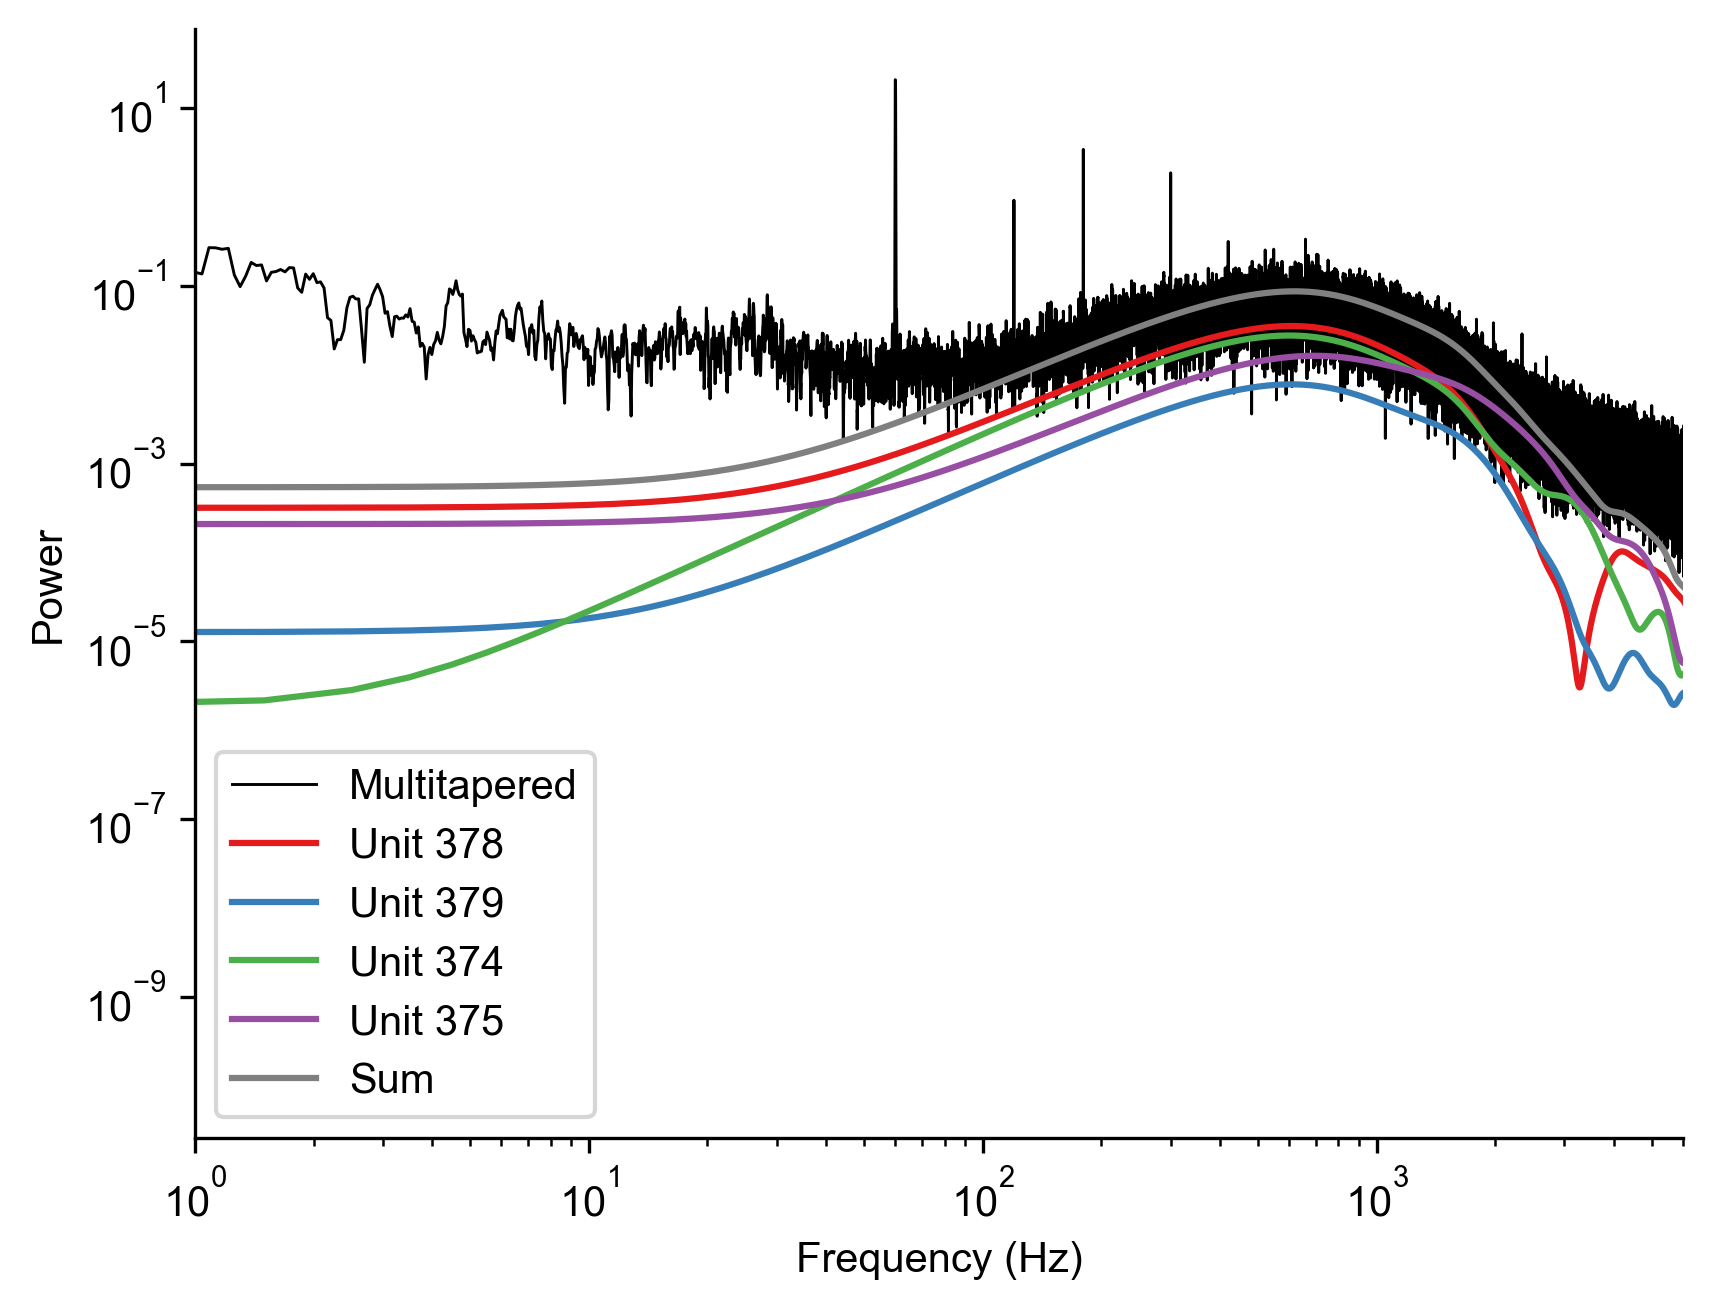

In [272]:
plt.figure(dpi=300)
plt.loglog(mt_freqs, ch208_PSD, color='k', label='Multitapered', linewidth=0.7)
plt.loglog(theor_freqs, u378_theor_PSD, color=cmap(0), label='Unit 378')
plt.loglog(theor_freqs, u379_theor_PSD, color=cmap(1), label='Unit 379')
plt.loglog(theor_freqs, u374_theor_PSD, color=cmap(2), label='Unit 374')
plt.loglog(theor_freqs, u375_theor_PSD, color=cmap(3), label='Unit 375')
plt.loglog(theor_freqs, u378_theor_PSD+u379_theor_PSD+u374_theor_PSD+u375_theor_PSD, color='gray', label='Sum')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.xlim((1,6000))
plt.legend()

The sum of the theoretical power spectra are able to match the power of the multitapered spectrum within the 300-2000 range which corresponds to the spiking band. However, with other channels, the summed spike spectra cannot explain the amplitude nor shape of the channel signal spectrum. We can use the GLM and Q-Q plot to see if this matches our assumption within the band.

Multitaper frequency resolution: 0.2608695652173913
Multitaper number of tapers: 5


/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Theoretical lambda_0:      13.783
Estimated lambda_0:        -82.954
Gamma Dispersion (phi):    0.406
Gamma Shape (k):           2.466


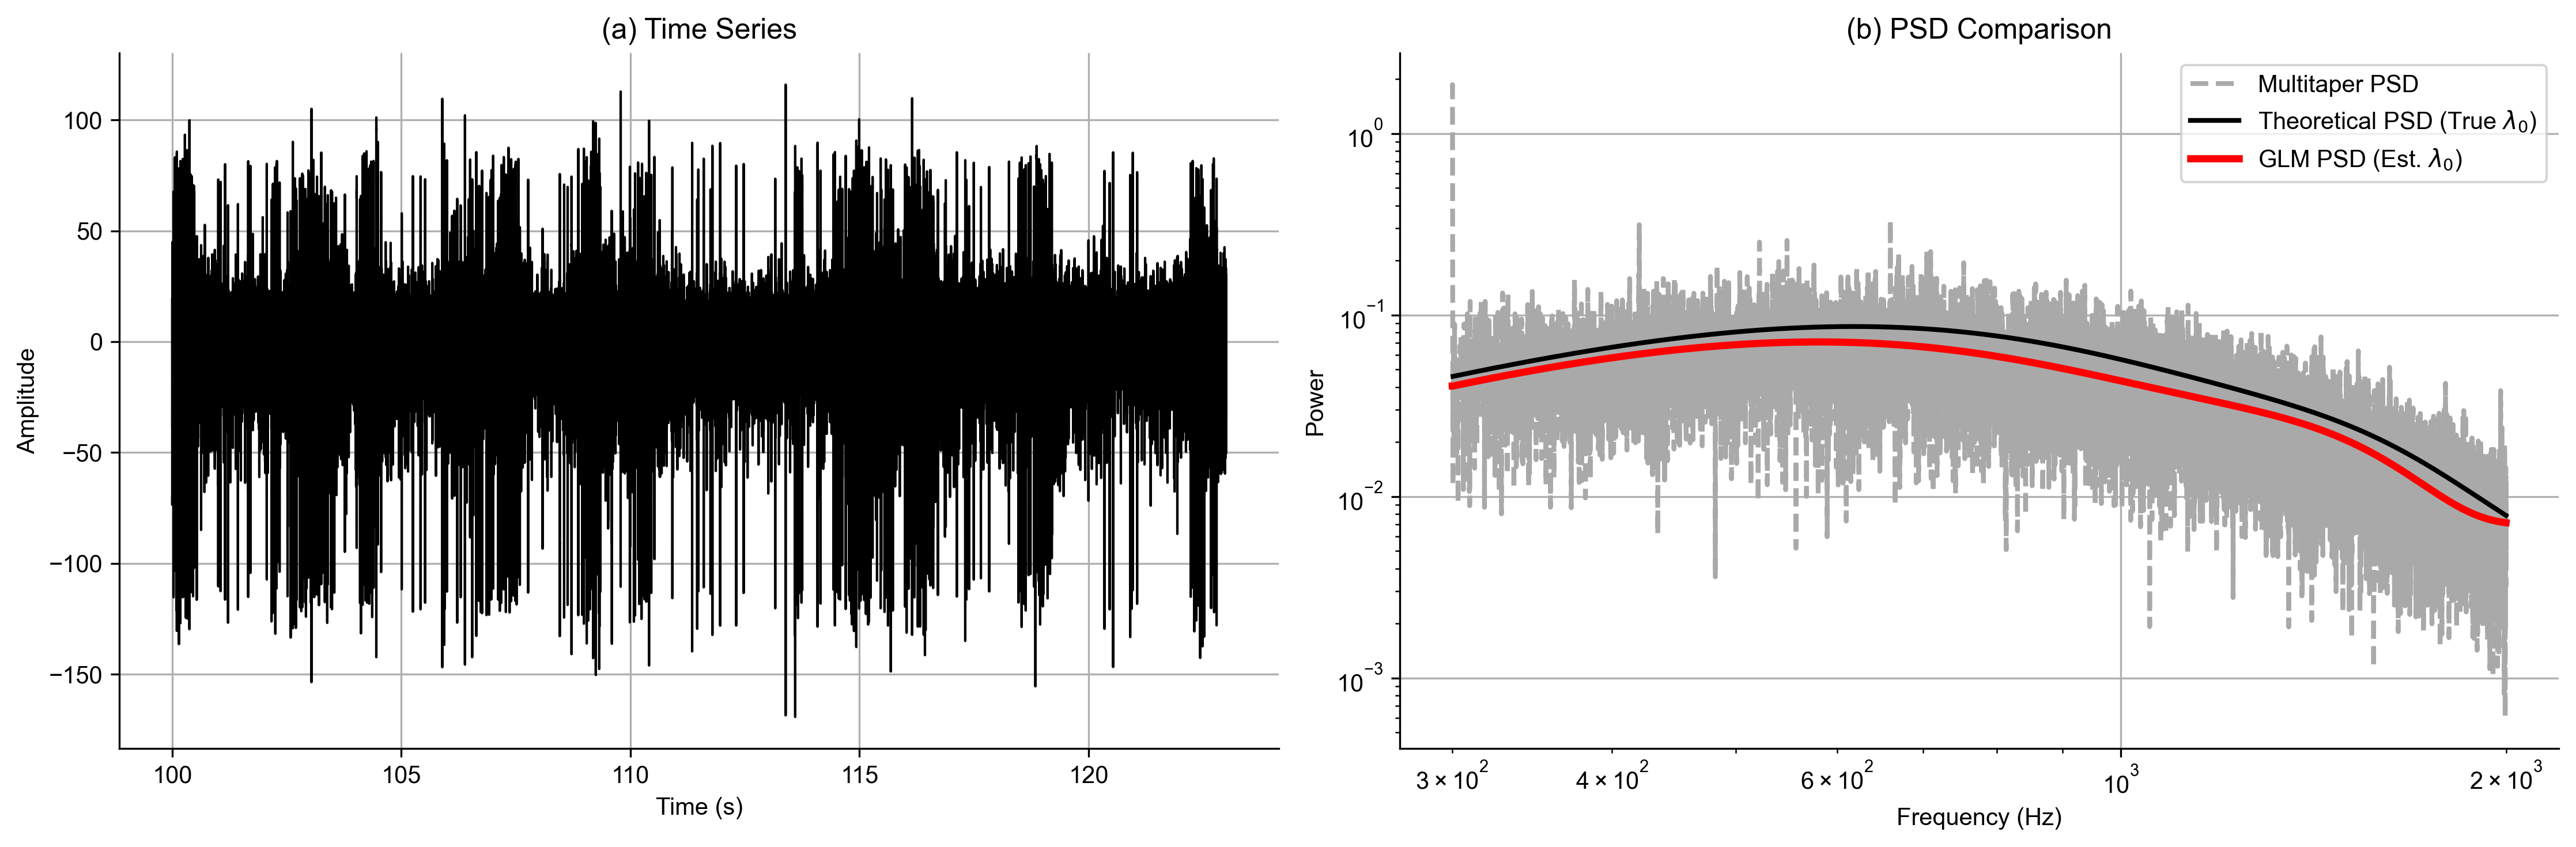

In [275]:
fppglm = FPPGLM(time_series=channel_signals['ch208'].time_series,
                time_axis=channel_signals['ch208'].time_axis,
                fs=channel_signals['ch208'].fs)

obs_firing_rates = np.array([channel_signals['ch208'].firing_rates[378],
                             channel_signals['ch208'].firing_rates[379],
                             channel_signals['ch205'].firing_rates[374],
                             channel_signals['ch205'].firing_rates[375]])

fppglm.fit(filter_psd_list=[u378_filters['waveform_instance']['filter_psd_iaw'],
                            u379_filters['waveform_instance']['filter_psd_iaw'],
                            u374_filters['waveform_instance']['filter_psd_iaw'],
                            u375_filters['waveform_instance']['filter_psd_iaw']],
           lambda_observed=obs_firing_rates,
           theoretical_frequencies=theor_freqs, bias=False,
           freq_range=(300,2000))

fppglm.plot_results()

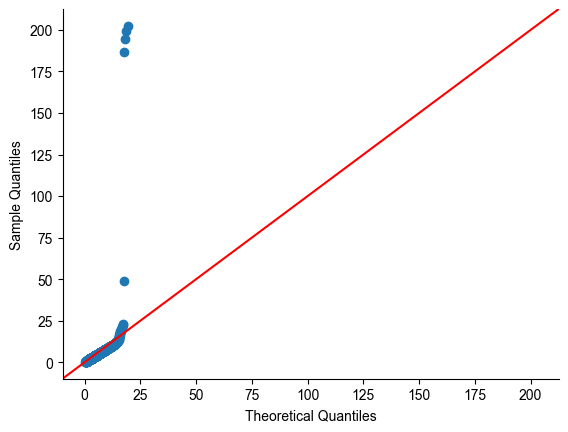

In [276]:
Z_f = (5 * fppglm.multitaper_psd_truncated) / fppglm.theoretical_psd_interpolated

sm.qqplot(Z_f, dist=gamma, distargs=(5,), line='45')
plt.show()

Although the theoretical and GLM-predicted PSD seem to match the multitapered spectrum well, the firing rate estimates were not accurate. This may be due to 1) the GLM fitting procedure allowing coefficients to be negative and 2) the similar waveform shapes resulting in multicollinearity. Perhaps non-negative least squares can be used to more accurately decode the firing rates. However, the quantiles under 25 seem to fit the model well, therefore we may need to further restrict the frequency range.

### Time-varying firing rates

We also want to see if FPP-based inverse modeling can detect the temporal dynamics of unit and population firing rates. We can use a state-space model to infer the firing rate from the multitapered spectrograms. The latent variable will be an AR(1) process describing the firing rate, which again under the FPP model scales the unit filter to produce the power spectrum of the nearby recorded signal. Thus, the observations would be the spectra within the spectrograms throughout time, which are assumed to be Gamma distributed.

$$
x_t=\alpha x_{t-1} + \epsilon,\ \epsilon\sim \mathcal{N}(0,\sigma^2)\\

\lambda_t = x_t + \bar{x}\\

y_t\sim \Gamma(\text{No. tapers}, \frac{\lambda_t\cdot S_{predictor}}{\text{No. tapers}})
$$

In [6]:
import pymc as pm
import pytensor.tensor as pt
import pytensor
import arviz as az
pytensor.config.optdb__max_use_ratio = 20.0

In [42]:
ch163spectrogram = fn.spectrafuncs.multitaper_spectrogram(channel_signals['ch163'].time_series,
                                                fs, time_halfbandwidth_product=5.75,
                                                window_duration=0.5, window_step=0.5,
                                                start_time=channel_signals['ch13'].time_axis[0])

In [43]:
freq_range = (1,5000)

c163spectrogram_trunc,c163spec_freqs_trunc = fn.spectrafuncs.spectrum_trunc(ch163spectrogram.frequencies,
                                                                             ch163spectrogram.power().squeeze(),
                                                                             freq_range, True)

u296psd_trunc,theor_freqs_trunc = fn.spectrafuncs.spectrum_trunc(theor_freqs,
                                                                 u296_filters['average_waveform']['filter_psd'],
                                                                 freq_range)
u296psd_interp = fn.spectrafuncs.spectrum_interp(c163spec_freqs_trunc,
                                                 theor_freqs_trunc,
                                                 u296psd_trunc)                                                                             

In [ ]:
def build_model_with_baseline(y_data, S_psp_interpolated, x_bar):
    """
    State-Space Model with AR(1) deviations around a known baseline x_bar:
        d_t = α * d_{t-1} + Normal(0, σ²)
        x_t = d_t + x_bar
    Observations:
        y_{t,f} ~ Gamma(shape=1, rate=1 / (x_t * S_psp_f))
    Now, α is a hyperparameter with a Uniform prior.
    """
    n_time, n_freq = y_data.shape
    with pm.Model() as model:
        # Hyperparameter: α (AR(1) coefficient) to be estimated
        alpha = pm.Uniform("alpha", lower=0.3, upper=0.99)
        # Hyperparameter: σ (innovation noise standard deviation)
        sigma = pm.Exponential("sigma", lam=0.01)
        # Initial deviation d_0 ~ Normal(0, 100^2)
        d_0 = pm.Normal("d_0", mu=0.0, sigma=100.0)
        # Baseline firing rate
        x_init = pm.Uniform("x_init", lower=2, upper=)
        # Build the AR(1) dynamics for the deviations
        d_states = [d_0]
        for t in range(1, n_time):
            d_t = pm.Normal(f"d_{t}", mu=alpha * d_states[t - 1], sigma=sigma)
            d_states.append(d_t)
        d_stack = pt.stack(d_states)  # shape: (n_time,)
        # Reconstruct the latent state: x_t = d_t + x_bar
        x_stack = d_stack + x_init
        # Compute the mean for each time-frequency bin
        S_tf = x_stack[:, None] * S_psp_interpolated[None, :]
        # Gamma likelihood with shape=1 so that mean = S_tf
        y_obs = pm.Gamma("y_obs", alpha=1, beta=1/S_tf, observed=y_data)
    return model

In [19]:
# 2) Build & sample with Method B (Baseline + Deviations).
model_b = build_model_with_baseline(
    y_data=c163spectrogram_trunc.squeeze(),
    S_psp_interpolated=u296psd_interp,
    x_bar=20
)
with model_b:
    trace_b = pm.sample(
        draws=1000, tune=1000, target_accept=0.9,
        random_seed=42
    )
# Summarize results for Method B
d_vars_b = ["sigma"] + [f"d_{t}" for t in range(c163spectrogram_trunc.shape[0])]
# print("\n=== METHOD B (Baseline + Deviations) ===")
# print(az.summary(trace_b, var_names=d_vars_b))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, d_10, d_11, d_12, d_13, d_14, d_15, d_16, d_17, d_18, d_19, d_20, d_21, d_22, d_23, d_24, d_25, d_26, d_27, d_28, d_29, d_30, d_31, d_32, d_33, d_34, d_35, d_36, d_37, d_38, d_39, d_40, d_41, d_42, d_43, d_44, d_45]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8267 seconds.


In [20]:
ssm_preds = []

for i in range(46):
    ssm_preds.append(trace_b.posterior.data_vars[f'd_{i}'].mean().values)

ssm_preds = np.array(ssm_preds)

In [24]:
Nt = int(fs * (time_window[1] - time_window[0]))
Nt

690000

In [30]:
from numpy.lib.stride_tricks import sliding_window_view

In [31]:
# calculate empircal firing rates
twindow2 = int(0.5 * fs)
tstep2 = int(0.5 * fs)

u296spktrain = np.zeros(Nt)
u296spktrain[channel_signals['ch163'].spike_times[296].astype(int)] = 1
u296_windowed_spktrain = sliding_window_view(u296spktrain, window_shape=twindow2)
u296_fr = u296_windowed_spktrain[::tstep2].sum(axis=1) / 0.5

x_bar = ssm_preds.mean() - u296_fr.mean()

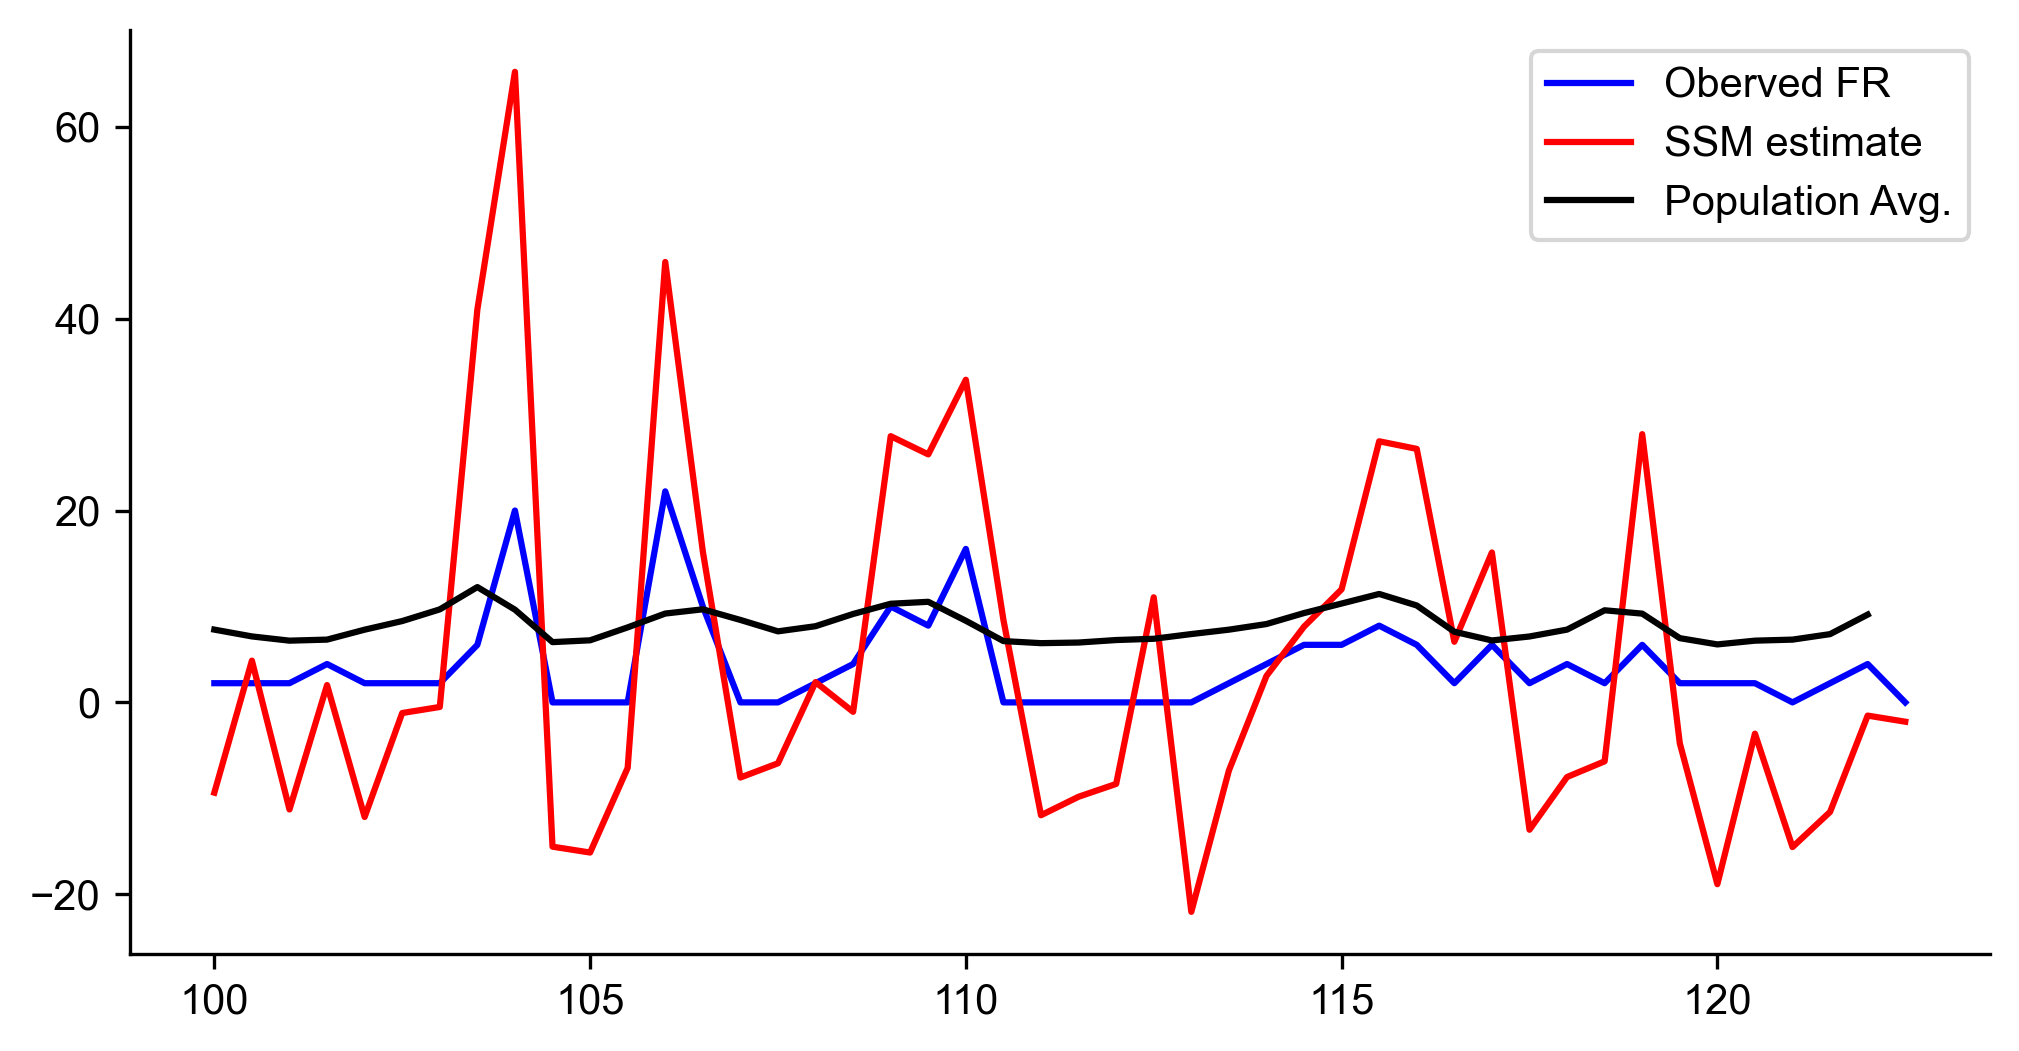

In [41]:
plt.figure(figsize=(8,4), dpi=300)
plt.plot(ch163spectrogram.time, u296_fr, label='Oberved FR', color='blue')
plt.plot(ch163spectrogram.time, ssm_preds - x_bar, label='SSM estimate', color='r')
plt.plot(fr_t, mean_pop_firing_rate, color='k', label='Population Avg.')
plt.legend()

As we can see, the state-space model estimate follows the empirical firing rate of the unit well. However, we still need to 1) establish a prior on $\bar{x}$ 2) calculate credible intervals for the state-space model estimates 3) prevent negative firing rates 4) use goodness-of-fit to further assess the model 5) apply state-space decoding to entire population averaged firing rates, broad-spiking/narrow-spiking population averaged firing rates, and WaveMAP cluster averaged firing rates.

## Conclusions

We have utilized a filtered point process to investigate the neuronal contributions to the electrophysiological power spectrum. We found that the firing rate of individual units located around the channel explained power within a specific frequency band and that firing rates could only reliably be decoded with FPP-based inverse modeling in the absence of background noise. We used nonlinear dimensionality reduction to cluster the waveforms and determined that waveforms as filters share similar shapes, possibly making decoding difficult or impossible. We also found that state-space models based on multitapered spectorgrams capture the temporal dynamics of the firing rates of a localized unit, but we have yet to assess model fit. Overall, this shows promise for understanding the individual neuronal contributions to the electrophysiological power spectrum with possibilities of untangling the population contributions to signals at different spatial scales.